# Applied Machine Learning Summative

### Packages

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
import re
from collections import Counter
import random

import sklearn
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer, quantile_transform, StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error, f1_score, roc_auc_score, classification_report, brier_score_loss
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction import _stop_words
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, mutual_info_classif, mutual_info_regression
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor, XGBClassifier

import shap
shap.initjs()

#from skopt import BayesSearchCV

import nltk, string
from nltk import edit_distance
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Load the data

Given all the background data from birth to year 9 and some training data from year 15, how well could participants infer six key outcomes in the year 15 test data?
What area am i exploring? 

Less Explored Angles

- The Role of Siblings:
    - Does the number of siblings impact GPA, potentially due to competition for resources or older siblings serving as role models?
    - Is the birth order of a child related to their academic performance?
- Paternal Involvement:
    - Does a father's active participation in a child's life (emotional support, help with academics) predict higher GPA, particularly for boys?
    - Could higher paternal involvement offset some negative effects of low maternal involvement on GPA?
- Media & Technology Influences:
    - Does a child's screen time or exposure to specific types of media content (educational vs. entertainment) have a measurable effect on GPA?
    - Are there links between social media use, cyberbullying experiences, and academic performance?
- Granular Time Influences:
    - Do life events occurring close to academic assessment points (e.g., parental job loss, family move, health crisis) temporarily affect GPA?
    - Do short-term fluctuations in factors like sleep quality or nutrition correlate with immediate changes in GPA?
- The Intersection of GPA and Non-Cognitive Skills:
    - Do students with higher social-emotional skills (self-regulation, resilience) show smaller academic declines when facing adversity?
    - Does high GPA paired with low self-efficacy predict different future outcomes than high GPA paired with high self-efficacy?

In [3]:
data_dir = Path.cwd()
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore the DtypeWarning
    background = pd.read_csv(f'{data_dir}/FFChallenge_v5/background.csv', sep=',', 
                             header=0,index_col=0)

# train.csv contains 2,121 rows (one per child in the training set) and 7 columns
train = pd.read_csv(f'{data_dir}/FFChallenge_v5/train.csv', sep=',', header=0, 
                    index_col=0)

# constantVariables.txt gives the column names of variables that are constant 
# in the data
constantVariables = pd.read_csv(f'{data_dir}/FFChallenge_v5/constantVariables.txt',
                                header=None, index_col=0)

# Load test/evaluation data
test = pd.read_csv(f'{data_dir}/FFChallenge_v5/prediction.csv', index_col='challengeID')

In [4]:
background = pd.read_csv("/Users/Applied Machine Learning/Summative/FFChallenge_v5/background.csv", low_memory=False)
background.head()

challengeID  cf1intmon  cf1intyr  cf1lenhr  cf1lenmin  cf1twoc  cf1fint  \
0            1         -3        -3        -9         -9       -3        0   
1            2         -3        -3         0         40       -3        1   
2            3         -3        -3         0         45       -3        1   
3            4         -3        -3         0         45       -3        1   
4            5         -3        -3        -6         50       -3        1   

   cf1natsm  f1natwt  cf1natsmx  ...      m4d9      m4e23       f4d6  \
0        -3       -3         -3  ...  6.269946   5.180325   2.511131   
1        -3       -3         -3  ...  6.269946  27.680196   2.511131   
2        -3       -3         -3  ...  6.269946   5.180325  20.867881   
3        -3       -3         -3  ...  6.269946   5.180325  22.018875   
4        -3       -3         -3  ...  6.269946   5.180325  22.916602   

        f4d7      f4d9       m5c6      m5d20     m5k10       f5c6       k5f1  
0   1.718804  6.473537  16.369411   4.476881  9.628369  15.981275  24.038266  
1   1.718804  6.473537  16.369411  26.671897  9.628369  15.981275   3.667679  
2  24.115867  6.473537  16.369411   4.476881  9.628369  15.981275  24.038266  
3  22.932641  6.473537  -5.169243   4.476881  9.628369  -6.303171   4.140511  
4  22.988036  6.473537  -6.034660   4.476881  9.628369  -6.211828   3.668879  

[5 rows x 13027 columns]

In [5]:
train = pd.read_csv("/Users/Applied Machine Learning/Summative/FFChallenge_v5/train.csv")

In [6]:
background.head()

challengeID  cf1intmon  cf1intyr  cf1lenhr  cf1lenmin  cf1twoc  cf1fint  \
0            1         -3        -3        -9         -9       -3        0   
1            2         -3        -3         0         40       -3        1   
2            3         -3        -3         0         45       -3        1   
3            4         -3        -3         0         45       -3        1   
4            5         -3        -3        -6         50       -3        1   

   cf1natsm  f1natwt  cf1natsmx  ...      m4d9      m4e23       f4d6  \
0        -3       -3         -3  ...  6.269946   5.180325   2.511131   
1        -3       -3         -3  ...  6.269946  27.680196   2.511131   
2        -3       -3         -3  ...  6.269946   5.180325  20.867881   
3        -3       -3         -3  ...  6.269946   5.180325  22.018875   
4        -3       -3         -3  ...  6.269946   5.180325  22.916602   

        f4d7      f4d9       m5c6      m5d20     m5k10       f5c6       k5f1  
0   1.718804  6.473537  16.369411   4.476881  9.628369  15.981275  24.038266  
1   1.718804  6.473537  16.369411  26.671897  9.628369  15.981275   3.667679  
2  24.115867  6.473537  16.369411   4.476881  9.628369  15.981275  24.038266  
3  22.932641  6.473537  -5.169243   4.476881  9.628369  -6.303171   4.140511  
4  22.988036  6.473537  -6.034660   4.476881  9.628369  -6.211828   3.668879  

[5 rows x 13027 columns]

In [7]:
#We start with 13026 features

### Data Preprocessing

#### Step 1: Drop constant columns

In [8]:
background = background.drop(constantVariables.index.values, axis = 1)

In [9]:
background.head()

challengeID  cf1lenhr  cf1lenmin  cf1fint  cf1citsm   f1citywt  f1a2  f1a3  \
0            1        -9         -9        0        -9  -3.000000    -9    -9   
1            2         0         40        1         1  68.455658     2     1   
2            3         0         45        1         1  42.319057     1     1   
3            4         0         45        1         1  25.628830     1     1   
4            5        -6         50        1         1  41.954487     2     1   

   f1a4  f1a4a  ...      m4d9      m4e23       f4d6       f4d7      f4d9  \
0    -9     -9  ...  6.269946   5.180325   2.511131   1.718804  6.473537   
1     1     -6  ...  6.269946  27.680196   2.511131   1.718804  6.473537   
2     1     -6  ...  6.269946   5.180325  20.867881  24.115867  6.473537   
3     1     -6  ...  6.269946   5.180325  22.018875  22.932641  6.473537   
4     1     -6  ...  6.269946   5.180325  22.916602  22.988036  6.473537   

        m5c6      m5d20     m5k10       f5c6       k5f1  
0  16.369411   4.476881  9.628369  15.981275  24.038266  
1  16.369411  26.671897  9.628369  15.981275   3.667679  
2  16.369411   4.476881  9.628369  15.981275  24.038266  
3  -5.169243   4.476881  9.628369  -6.303171   4.140511  
4  -6.034660   4.476881  9.628369  -6.211828   3.668879  

[5 rows x 10595 columns]

In [10]:
#2,432 features are dropped by removing the constant variables

#### Step 2: Drop non-numeric columns

In [11]:
object_cols = background.select_dtypes(include='object').columns
background[object_cols]


d3a23_a d3c5a_14ot d3c12_b1 d3c12_b2 d3c13 d3c13a_9ot d3c14 d3c14a_9ot  \
0        NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
1        NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
2        NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
3        NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
4        NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
...      ...        ...      ...      ...   ...        ...   ...        ...   
4237     NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
4238     NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
4239     NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
4240     NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   
4241     NaN        NaN      NaN      NaN   NaN        NaN   NaN        NaN   

     d3g22a_9ot d3g23a_got  ... q5citywt_rep63 q5citywt_rep64 q5citywt_rep65  \
0           NaN        NaN  ...            NaN            NaN            NaN   
1           NaN        NaN  ...          Other          Other          Other   
2           NaN        NaN  ...            NaN            NaN            NaN   
3           NaN        NaN  ...          Other          Other          Other   
4           NaN        NaN  ...          Other          Other          Other   
...         ...        ...  ...            ...            ...            ...   
4237        NaN        NaN  ...          Other          Other          Other   
4238        NaN        NaN  ...          Other          Other          Other   
4239        NaN        NaN  ...            NaN            NaN            NaN   
4240        NaN        NaN  ...          Other          Other          Other   
4241        NaN        NaN  ...          Other          Other          Other   

     q5citywt_rep66 q5citywt_rep67 q5citywt_rep68 q5citywt_rep69  \
0               NaN            NaN            NaN            NaN   
1             Other          Other          Other          Other   
2               NaN            NaN            NaN            NaN   
3             Other          Other          Other          Other   
4             Other          Other          Other          Other   
...             ...            ...            ...            ...   
4237          Other          Other          Other          Other   
4238          Other          Other          Other          Other   
4239            NaN            NaN            NaN            NaN   
4240          Other          Other          Other          Other   
4241          Other          Other          Other          Other   

     q5citywt_rep70 q5citywt_rep71 q5citywt_rep72  
0               NaN            NaN            NaN  
1             Other          Other          Other  
2               NaN            NaN            NaN  
3             Other          Other          Other  
4             Other          Other          Other  
...             ...            ...            ...  
4237          Other          Other          Other  
4238          Other          Other          Other  
4239            NaN            NaN            NaN  
4240          Other          Other          Other  
4241          Other          Other          Other  

[4242 rows x 115 columns]

In [12]:
object_cols = background.select_dtypes(include='object').columns
background[object_cols] = background[object_cols].replace('Other', np.nan)


#### Step 3: Drop non-numeric columns

In [13]:
# Drop non-numeric columns
background = background[background.columns[background.dtypes!='object']]

In [14]:
background.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4242 entries, 0 to 4241
Columns: 10493 entries, challengeID to k5f1
dtypes: float64(554), int64(9939)
memory usage: 339.6 MB


In [15]:
background.head()

challengeID  cf1lenhr  cf1lenmin  cf1fint  cf1citsm   f1citywt  f1a2  f1a3  \
0            1        -9         -9        0        -9  -3.000000    -9    -9   
1            2         0         40        1         1  68.455658     2     1   
2            3         0         45        1         1  42.319057     1     1   
3            4         0         45        1         1  25.628830     1     1   
4            5        -6         50        1         1  41.954487     2     1   

   f1a4  f1a4a  ...      m4d9      m4e23       f4d6       f4d7      f4d9  \
0    -9     -9  ...  6.269946   5.180325   2.511131   1.718804  6.473537   
1     1     -6  ...  6.269946  27.680196   2.511131   1.718804  6.473537   
2     1     -6  ...  6.269946   5.180325  20.867881  24.115867  6.473537   
3     1     -6  ...  6.269946   5.180325  22.018875  22.932641  6.473537   
4     1     -6  ...  6.269946   5.180325  22.916602  22.988036  6.473537   

        m5c6      m5d20     m5k10       f5c6       k5f1  
0  16.369411   4.476881  9.628369  15.981275  24.038266  
1  16.369411  26.671897  9.628369  15.981275   3.667679  
2  16.369411   4.476881  9.628369  15.981275  24.038266  
3  -5.169243   4.476881  9.628369  -6.303171   4.140511  
4  -6.034660   4.476881  9.628369  -6.211828   3.668879  

[5 rows x 10493 columns]

In [16]:
#115 features are dropped by removing the non-numeric columns

In [17]:
#Any infinite values are replaced with NaN

In [18]:
variables = background.columns
background[background < 0] = np.nan
n_col = len(background.columns)
n_rows = len(background)
n_col

10493

#### Step 4: Identify colunns with high missingness

In [19]:
# Identify columns with high missingness
threshold = 0.8
high_missingness = 0
columns_to_use = []
outcomes = list(train.columns)

for c in background.columns:
    if c not in outcomes:
        missing_prop = (background[c].isnull().sum() / background.shape[0])
        if missing_prop > threshold:
            high_missingness += 1
        else:
            columns_to_use.append(c)
    else:  # if it is an outcome column then always keep it
        columns_to_use.append(c)

print(str(high_missingness), " columns with over ", str(threshold * 100), " percent missing")



5315  columns with over  80.0  percent missing


#### Step 5: Identify columns with low variance

In [20]:
# Calculate the variance of each column
variances = background.var()

# Identify columns with variance less than 0.05
low_variance_cols = variances[variances < 0.05]

# Get the number of columns with variance less than 0.05
num_low_variance_cols = len(low_variance_cols)

# Print the result
print("Number of columns with variance less than 0.05:", num_low_variance_cols)


Number of columns with variance less than 0.05: 1482


In [21]:
background.drop(low_variance_cols.index, axis=1, inplace=True)


In [22]:
background.head()

challengeID  cf1lenhr  cf1lenmin  cf1fint   f1citywt  f1a2  f1a3  f1a4  \
0            1       NaN        NaN        0        NaN   NaN   NaN   NaN   
1            2       0.0       40.0        1  68.455658   2.0   1.0   1.0   
2            3       0.0       45.0        1  42.319057   1.0   1.0   1.0   
3            4       0.0       45.0        1  25.628830   1.0   1.0   1.0   
4            5       NaN       50.0        1  41.954487   2.0   1.0   1.0   

   f1a4a  f1a5a  ...       m4d6       m4d7      m4d9      m4e23       f4d6  \
0    NaN    NaN  ...   2.351121   1.235117  6.269946   5.180325   2.511131   
1    NaN    NaN  ...   2.351121   1.235117  6.269946  27.680196   2.511131   
2    NaN    NaN  ...   2.351121   1.235117  6.269946   5.180325  20.867881   
3    NaN    NaN  ...  21.220233  23.172680  6.269946   5.180325  22.018875   
4    NaN    NaN  ...  21.386605  23.227584  6.269946   5.180325  22.916602   

        f4d7      f4d9      m5d20     m5k10       k5f1  
0   1.718804  6.473537   4.476881  9.628369  24.038266  
1   1.718804  6.473537  26.671897  9.628369   3.667679  
2  24.115867  6.473537   4.476881  9.628369  24.038266  
3  22.932641  6.473537   4.476881  9.628369   4.140511  
4  22.988036  6.473537   4.476881  9.628369   3.668879  

[5 rows x 9011 columns]

In [23]:
background.dropna(thresh=background.shape[0]*0.2, axis=1, inplace=True)


In [24]:
background.head()

challengeID  cf1lenhr  cf1lenmin  cf1fint   f1citywt  f1a2  f1a3  f1a4  \
0            1       NaN        NaN        0        NaN   NaN   NaN   NaN   
1            2       0.0       40.0        1  68.455658   2.0   1.0   1.0   
2            3       0.0       45.0        1  42.319057   1.0   1.0   1.0   
3            4       0.0       45.0        1  25.628830   1.0   1.0   1.0   
4            5       NaN       50.0        1  41.954487   2.0   1.0   1.0   

   f1a6  f1a6a  ...       m4d6       m4d7      m4d9      m4e23       f4d6  \
0   NaN    NaN  ...   2.351121   1.235117  6.269946   5.180325   2.511131   
1   1.0    4.0  ...   2.351121   1.235117  6.269946  27.680196   2.511131   
2   2.0    NaN  ...   2.351121   1.235117  6.269946   5.180325  20.867881   
3   2.0    NaN  ...  21.220233  23.172680  6.269946   5.180325  22.018875   
4   2.0    NaN  ...  21.386605  23.227584  6.269946   5.180325  22.916602   

        f4d7      f4d9      m5d20     m5k10       k5f1  
0   1.718804  6.473537   4.476881  9.628369  24.038266  
1   1.718804  6.473537  26.671897  9.628369   3.667679  
2  24.115867  6.473537   4.476881  9.628369  24.038266  
3  22.932641  6.473537   4.476881  9.628369   4.140511  
4  22.988036  6.473537   4.476881  9.628369   3.668879  

[5 rows x 4611 columns]

In [25]:
df_background = background.copy()

In [26]:
# df_background = pd.concat([df_background, train], axis=1, join='outer')

In [27]:
#df_background = pd.merge(train['challengeID'], df_background, left_index=True, right_index=True)

In [28]:
df_background

challengeID  cf1lenhr  cf1lenmin  cf1fint   f1citywt  f1a2  f1a3  f1a4  \
0               1       NaN        NaN        0        NaN   NaN   NaN   NaN   
1               2       0.0       40.0        1  68.455658   2.0   1.0   1.0   
2               3       0.0       45.0        1  42.319057   1.0   1.0   1.0   
3               4       0.0       45.0        1  25.628830   1.0   1.0   1.0   
4               5       NaN       50.0        1  41.954487   2.0   1.0   1.0   
...           ...       ...        ...      ...        ...   ...   ...   ...   
4237         4238       NaN        NaN        0        NaN   NaN   NaN   NaN   
4238         4239       0.0       40.0        1  64.195152   2.0   1.0   1.0   
4239         4240       NaN        NaN        0        NaN   NaN   NaN   NaN   
4240         4241       1.0        0.0        1  27.461493   2.0   1.0   2.0   
4241         4242       NaN        NaN        0        NaN   NaN   NaN   NaN   

      f1a6  f1a6a  ...       m4d6       m4d7       m4d9      m4e23       f4d6  \
0      NaN    NaN  ...   2.351121   1.235117   6.269946   5.180325   2.511131   
1      1.0    4.0  ...   2.351121   1.235117   6.269946  27.680196   2.511131   
2      2.0    NaN  ...   2.351121   1.235117   6.269946   5.180325  20.867881   
3      2.0    NaN  ...  21.220233  23.172680   6.269946   5.180325  22.018875   
4      2.0    NaN  ...  21.386605  23.227584   6.269946   5.180325  22.916602   
...    ...    ...  ...        ...        ...        ...        ...        ...   
4237   NaN    NaN  ...   2.351121   1.235117  27.941956   5.180325   2.511131   
4238   2.0    NaN  ...   2.351121   1.235117  28.703663   5.180325   2.511131   
4239   NaN    NaN  ...   2.351121   1.235117   6.269946  26.990283   2.511131   
4240   1.0    1.0  ...   2.351121   1.235117   6.269946  27.189692   2.511131   
4241   NaN    NaN  ...  21.096649  23.030114   6.269946   5.180325  23.558317   

           f4d7       f4d9      m5d20     m5k10       k5f1  
0      1.718804   6.473537   4.476881  9.628369  24.038266  
1      1.718804   6.473537  26.671897  9.628369   3.667679  
2     24.115867   6.473537   4.476881  9.628369  24.038266  
3     22.932641   6.473537   4.476881  9.628369   4.140511  
4     22.988036   6.473537   4.476881  9.628369   3.668879  
...         ...        ...        ...       ...        ...  
4237   1.718804   6.473537   4.476881  9.628369  24.038266  
4238   1.718804   6.473537   4.476881  9.628369   3.424922  
4239   1.718804   6.473537   4.476881  9.628369  24.038266  
4240   1.718804  28.512659   4.476881  9.628369   3.656543  
4241  23.937457   6.473537   4.476881  9.628369   3.424922  

[4242 rows x 4611 columns]

In [29]:
df_background.set_index('challengeID', inplace=True)

In [30]:
train

challengeID   gpa  grit  materialHardship  eviction  layoff  jobTraining
0               1   NaN   NaN               NaN       NaN     NaN          NaN
1               3   NaN   NaN               NaN       NaN     NaN          NaN
2               6   NaN  3.50          0.090909       0.0     0.0          0.0
3               7  2.50  3.25          0.000000       0.0     0.0          0.0
4               8   NaN   NaN               NaN       NaN     NaN          NaN
...           ...   ...   ...               ...       ...     ...          ...
2116         4235   NaN   NaN               NaN       NaN     NaN          NaN
2117         4236   NaN  3.75          0.000000       0.0     0.0          0.0
2118         4239  2.75  2.75          0.000000       0.0     0.0          0.0
2119         4240   NaN   NaN               NaN       NaN     NaN          NaN
2120         4241  3.00  4.00          0.000000       0.0     1.0          1.0

[2121 rows x 7 columns]

In [31]:
train1 = train.dropna()

In [32]:
train1

challengeID   gpa  grit  materialHardship  eviction  layoff  jobTraining
3               7  2.50  3.25          0.000000       0.0     0.0          0.0
5               9  2.25  4.00          0.181818       0.0     0.0          0.0
7              13  2.75  4.00          0.181818       0.0     0.0          1.0
8              14  3.25  2.75          0.272727       0.0     1.0          0.0
9              16  2.00  3.50          0.090909       0.0     0.0          1.0
...           ...   ...   ...               ...       ...     ...          ...
2108         4206  2.75  3.50          0.272727       0.0     0.0          0.0
2110         4216  2.00  3.00          0.000000       0.0     0.0          0.0
2114         4224  3.50  2.75          0.272727       0.0     0.0          1.0
2118         4239  2.75  2.75          0.000000       0.0     0.0          0.0
2120         4241  3.00  4.00          0.000000       0.0     1.0          1.0

[1014 rows x 7 columns]

In [33]:
# # Mean imputation for 'gpa', 'grit', and 'materialHardship'
# train['gpa'].fillna(train['gpa'].mean(), inplace=True)
# train['grit'].fillna(train['grit'].mean(), inplace=True)
# train['materialHardship'].fillna(train['materialHardship'].mean(), inplace=True)

# # Mode imputation for 'eviction', 'layoff', and 'jobTraining'
# train['eviction'].fillna(train['eviction'].mode()[0], inplace=True)
# train['layoff'].fillna(train['layoff'].mode()[0], inplace=True)
# train['jobTraining'].fillna(train['jobTraining'].mode()[0], inplace=True)


In [34]:
train

challengeID   gpa  grit  materialHardship  eviction  layoff  jobTraining
0               1   NaN   NaN               NaN       NaN     NaN          NaN
1               3   NaN   NaN               NaN       NaN     NaN          NaN
2               6   NaN  3.50          0.090909       0.0     0.0          0.0
3               7  2.50  3.25          0.000000       0.0     0.0          0.0
4               8   NaN   NaN               NaN       NaN     NaN          NaN
...           ...   ...   ...               ...       ...     ...          ...
2116         4235   NaN   NaN               NaN       NaN     NaN          NaN
2117         4236   NaN  3.75          0.000000       0.0     0.0          0.0
2118         4239  2.75  2.75          0.000000       0.0     0.0          0.0
2119         4240   NaN   NaN               NaN       NaN     NaN          NaN
2120         4241  3.00  4.00          0.000000       0.0     1.0          1.0

[2121 rows x 7 columns]

#### Step 6: Identify the Categorical and Continuous Variables

In [35]:
# Factorizing string fields
cat_cols = []
cont_cols = []
cat_vals_dict = {}

for c in df_background.columns:
    is_categorical = False
    vals = set(list(df_background[c].dropna()))  # Remove NaNs
    if df_background[c].dtype == 'float64':
        if len(vals) < 50:
            is_categorical = True
        else:
            is_categorical = False
    else:
        is_categorical = True
        df_background[c], _ = pd.factorize(df_background[c])  # factorize it to numeric
    if is_categorical:
        cat_cols.append(c)
        cat_vals_dict[c] = vals
    else:
        cont_cols.append(c)

categorical = df_background[cat_cols]
continuous = df_background[cont_cols]

In [36]:
df_background[cat_cols].dtypes.value_counts()

float64    4201
int64        14
Name: count, dtype: int64

#### Step 7: Scaler and Median Imputation for Continuous Variables

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Select the continuous columns
continuous_cols = df_background[cont_cols]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the train set
scaler.fit(continuous_cols)

# Standardize the continuous columns in df_background
df_background[cont_cols] = scaler.transform(continuous_cols)

# Create a SimpleImputer object with median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the train set
imputer.fit(df_background[cont_cols])

# Impute the missing values in df_background using median strategy
df_background[cont_cols] = imputer.transform(df_background[cont_cols])


In [38]:
df_background

cf1lenhr  cf1lenmin  cf1fint  f1citywt  f1a2  f1a3  f1a4  f1a6  \
challengeID                                                                   
1                 NaN   0.268663        0 -0.281746   NaN   NaN   NaN   NaN   
2                 0.0   0.268663        1 -0.153814   2.0   1.0   1.0   1.0   
3                 0.0   0.682495        1 -0.270578   1.0   1.0   1.0   2.0   
4                 0.0   0.682495        1 -0.345141   1.0   1.0   1.0   2.0   
5                 NaN   1.096328        1 -0.272207   2.0   1.0   1.0   2.0   
...               ...        ...      ...       ...   ...   ...   ...   ...   
4238              NaN   0.268663        0 -0.281746   NaN   NaN   NaN   NaN   
4239              0.0   0.268663        1 -0.172847   2.0   1.0   1.0   2.0   
4240              NaN   0.268663        0 -0.281746   NaN   NaN   NaN   NaN   
4241              1.0  -3.042000        1 -0.336954   2.0   1.0   2.0   1.0   
4242              NaN   0.268663        0 -0.281746   NaN   NaN   NaN   NaN   

             f1a6a   f1a7  ...      m4d6      m4d7      m4d9     m4e23  \
challengeID                ...                                           
1              NaN    NaN  ... -0.810995 -0.815804 -0.452366 -0.531279   
2              4.0    2.0  ... -0.810995 -0.815804 -0.452366  1.948909   
3              NaN  102.0  ... -0.810995 -0.815804 -0.452366 -0.531279   
4              NaN  101.0  ...  1.189658  1.226066 -0.452366 -0.531279   
5              NaN    1.0  ...  1.207298  1.231176 -0.452366 -0.531279   
...            ...    ...  ...       ...       ...       ...       ...   
4238           NaN    NaN  ... -0.810995 -0.815804  2.175930 -0.531279   
4239           NaN  101.0  ... -0.810995 -0.815804  2.268307 -0.531279   
4240           NaN    NaN  ... -0.810995 -0.815804 -0.452366  1.872859   
4241           1.0    2.0  ... -0.810995 -0.815804 -0.452366  1.894840   
4242           NaN    NaN  ...  1.176555  1.212796 -0.452366 -0.531279   

                 f4d6      f4d7      f4d9     m5d20     m5k10      k5f1  
challengeID                                                              
1           -0.781132 -0.784019 -0.441449 -0.581068 -0.144998  1.498944  
2           -0.781132 -0.784019 -0.441449  1.753992 -0.144998 -0.676137  
3            1.133583  1.336415 -0.441449 -0.581068 -0.144998  1.498944  
4            1.253638  1.224393 -0.441449 -0.581068 -0.144998 -0.625651  
5            1.347276  1.229638 -0.441449 -0.581068 -0.144998 -0.676009  
...               ...       ...       ...       ...       ...       ...  
4238        -0.781132 -0.784019 -0.441449 -0.581068 -0.144998  1.498944  
4239        -0.781132 -0.784019 -0.441449 -0.581068 -0.144998 -0.702058  
4240        -0.781132 -0.784019 -0.441449 -0.581068 -0.144998  1.498944  
4241        -0.781132 -0.784019  2.317447 -0.581068 -0.144998 -0.677326  
4242         1.414211  1.319524 -0.441449 -0.581068 -0.144998 -0.702058  

[4242 rows x 4610 columns]

In [39]:
df_background.reset_index(inplace=True)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


#### Step 8: Mode imputation and One hot Encoding for Categorical Variables

In [40]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Select the categorical columns
categorical_cols = df_background[cat_cols]

# Create a SimpleImputer object with mode strategy
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the train set
imputer.fit(categorical_cols)

# Impute the missing values in categorical_cols using mode strategy
categorical_cols = imputer.transform(categorical_cols)

# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

# Fit the encoder on the categorical_cols
encoder.fit(categorical_cols)

# Transform the categorical_cols into a sparse and binary representation
categorical_cols_encoded = encoder.transform(categorical_cols)

# Convert the encoded categorical_cols into a DataFrame
categorical_cols_encoded_df = pd.DataFrame(categorical_cols_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))

# Concatenate the encoded categorical_cols with the continuous_cols
df_encoded = pd.concat([df_background[cont_cols], categorical_cols_encoded_df], axis=1)


In [41]:
categorical_cols_encoded_df

cf1lenhr_0.0  cf1lenhr_1.0  cf1lenhr_2.0  cf1lenhr_5.0  cf1lenhr_7.0  \
0              1.0           0.0           0.0           0.0           0.0   
1              1.0           0.0           0.0           0.0           0.0   
2              1.0           0.0           0.0           0.0           0.0   
3              1.0           0.0           0.0           0.0           0.0   
4              1.0           0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...           ...   
4237           1.0           0.0           0.0           0.0           0.0   
4238           1.0           0.0           0.0           0.0           0.0   
4239           1.0           0.0           0.0           0.0           0.0   
4240           0.0           1.0           0.0           0.0           0.0   
4241           1.0           0.0           0.0           0.0           0.0   

      cf1lenhr_10.0  cf1lenhr_14.0  cf1lenhr_35.0  cf1fint_0.0  cf1fint_1.0  \
0               0.0            0.0            0.0          1.0          0.0   
1               0.0            0.0            0.0          0.0          1.0   
2               0.0            0.0            0.0          0.0          1.0   
3               0.0            0.0            0.0          0.0          1.0   
4               0.0            0.0            0.0          0.0          1.0   
...             ...            ...            ...          ...          ...   
4237            0.0            0.0            0.0          1.0          0.0   
4238            0.0            0.0            0.0          0.0          1.0   
4239            0.0            0.0            0.0          1.0          0.0   
4240            0.0            0.0            0.0          0.0          1.0   
4241            0.0            0.0            0.0          1.0          0.0   

      ...  cm5samp_5.0  cm5samp_6.0  cm5samp_7.0  cf5samp_1.0  cf5samp_2.0  \
0     ...          0.0          1.0          0.0          0.0          0.0   
1     ...          0.0          1.0          0.0          1.0          0.0   
2     ...          0.0          0.0          1.0          0.0          0.0   
3     ...          0.0          1.0          0.0          0.0          0.0   
4     ...          0.0          1.0          0.0          0.0          0.0   
...   ...          ...          ...          ...          ...          ...   
4237  ...          0.0          0.0          0.0          0.0          0.0   
4238  ...          0.0          1.0          0.0          0.0          0.0   
4239  ...          1.0          0.0          0.0          0.0          0.0   
4240  ...          0.0          1.0          0.0          0.0          0.0   
4241  ...          0.0          1.0          0.0          0.0          0.0   

      cf5samp_3.0  cf5samp_4.0  cf5samp_5.0  cf5samp_6.0  cf5samp_7.0  
0             0.0          0.0          0.0          1.0          0.0  
1             0.0          0.0          0.0          0.0          0.0  
2             0.0          0.0          0.0          0.0          1.0  
3             0.0          0.0          0.0          0.0          1.0  
4             0.0          0.0          0.0          0.0          1.0  
...           ...          ...          ...          ...          ...  
4237          1.0          0.0          0.0          0.0          0.0  
4238          0.0          0.0          0.0          0.0          1.0  
4239          0.0          0.0          0.0          1.0          0.0  
4240          0.0          0.0          0.0          0.0          1.0  
4241          0.0          0.0          0.0          0.0          1.0  

[4242 rows x 19698 columns]

In [42]:
df_encoded

cf1lenmin  f1citywt    f1e1d1    f1e1d2    f1e1d3      f1j6      f1j8  \
0      0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
1      0.268663 -0.153814 -0.239923 -0.246741 -0.228188  0.519528  1.142958   
2      0.682495 -0.270578  1.028997  1.642285  0.925195 -0.308768 -0.385464   
3      0.682495 -0.345141 -0.874383 -0.246741 -0.228188 -0.308768 -0.385532   
4      1.096328 -0.272207  3.919315  1.886030  3.520308  1.347825 -0.347516   
...         ...       ...       ...       ...       ...       ...       ...   
4237   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4238   0.268663 -0.172847  0.606024 -0.124868 -0.228188 -0.722917 -0.377650   
4239   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4240  -3.042000 -0.336954 -0.239923 -0.246741 -0.228188 -0.308768 -0.385110   
4241   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   

         f1j11     f1j12      f1k4  ...  cm5samp_5.0  cm5samp_6.0  \
0     0.522282 -0.317067 -0.137788  ...          0.0          1.0   
1     0.667379  0.517263  0.837701  ...          0.0          1.0   
2     0.667379 -0.317067  0.254060  ...          0.0          0.0   
3     0.522282 -0.317067 -0.057441  ...          0.0          1.0   
4    -1.654171  1.351593 -1.251722  ...          0.0          1.0   
...        ...       ...       ...  ...          ...          ...   
4237  0.522282 -0.317067 -0.137788  ...          0.0          0.0   
4238 -0.783590 -0.734232 -1.080309  ...          0.0          1.0   
4239  0.522282 -0.317067 -0.137788  ...          1.0          0.0   
4240 -1.218880 -0.317067  0.132004  ...          0.0          1.0   
4241  0.522282 -0.317067 -0.137788  ...          0.0          1.0   

      cm5samp_7.0  cf5samp_1.0  cf5samp_2.0  cf5samp_3.0  cf5samp_4.0  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          1.0          0.0          0.0          0.0   
2             1.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
4237          0.0          0.0          0.0          1.0          0.0   
4238          0.0          0.0          0.0          0.0          0.0   
4239          0.0          0.0          0.0          0.0          0.0   
4240          0.0          0.0          0.0          0.0          0.0   
4241          0.0          0.0          0.0          0.0          0.0   

      cf5samp_5.0  cf5samp_6.0  cf5samp_7.0  
0             0.0          1.0          0.0  
1             0.0          0.0          0.0  
2             0.0          0.0          1.0  
3             0.0          0.0          1.0  
4             0.0          0.0          1.0  
...           ...          ...          ...  
4237          0.0          0.0          0.0  
4238          0.0          0.0          1.0  
4239          0.0          1.0          0.0  
4240          0.0          0.0          1.0  
4241          0.0          0.0          1.0  

[4242 rows x 20093 columns]

#### Step 9: Apply 80% threshold to encoded features

In [43]:
df_encoded.dropna(thresh=df_encoded.shape[0]*0.3, axis=1, inplace=True)

In [44]:
df_encoded

cf1lenmin  f1citywt    f1e1d1    f1e1d2    f1e1d3      f1j6      f1j8  \
0      0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
1      0.268663 -0.153814 -0.239923 -0.246741 -0.228188  0.519528  1.142958   
2      0.682495 -0.270578  1.028997  1.642285  0.925195 -0.308768 -0.385464   
3      0.682495 -0.345141 -0.874383 -0.246741 -0.228188 -0.308768 -0.385532   
4      1.096328 -0.272207  3.919315  1.886030  3.520308  1.347825 -0.347516   
...         ...       ...       ...       ...       ...       ...       ...   
4237   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4238   0.268663 -0.172847  0.606024 -0.124868 -0.228188 -0.722917 -0.377650   
4239   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4240  -3.042000 -0.336954 -0.239923 -0.246741 -0.228188 -0.308768 -0.385110   
4241   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   

         f1j11     f1j12      f1k4  ...  cm5samp_5.0  cm5samp_6.0  \
0     0.522282 -0.317067 -0.137788  ...          0.0          1.0   
1     0.667379  0.517263  0.837701  ...          0.0          1.0   
2     0.667379 -0.317067  0.254060  ...          0.0          0.0   
3     0.522282 -0.317067 -0.057441  ...          0.0          1.0   
4    -1.654171  1.351593 -1.251722  ...          0.0          1.0   
...        ...       ...       ...  ...          ...          ...   
4237  0.522282 -0.317067 -0.137788  ...          0.0          0.0   
4238 -0.783590 -0.734232 -1.080309  ...          0.0          1.0   
4239  0.522282 -0.317067 -0.137788  ...          1.0          0.0   
4240 -1.218880 -0.317067  0.132004  ...          0.0          1.0   
4241  0.522282 -0.317067 -0.137788  ...          0.0          1.0   

      cm5samp_7.0  cf5samp_1.0  cf5samp_2.0  cf5samp_3.0  cf5samp_4.0  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          1.0          0.0          0.0          0.0   
2             1.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
4237          0.0          0.0          0.0          1.0          0.0   
4238          0.0          0.0          0.0          0.0          0.0   
4239          0.0          0.0          0.0          0.0          0.0   
4240          0.0          0.0          0.0          0.0          0.0   
4241          0.0          0.0          0.0          0.0          0.0   

      cf5samp_5.0  cf5samp_6.0  cf5samp_7.0  
0             0.0          1.0          0.0  
1             0.0          0.0          0.0  
2             0.0          0.0          1.0  
3             0.0          0.0          1.0  
4             0.0          0.0          1.0  
...           ...          ...          ...  
4237          0.0          0.0          0.0  
4238          0.0          0.0          1.0  
4239          0.0          1.0          0.0  
4240          0.0          0.0          1.0  
4241          0.0          0.0          1.0  

[4242 rows x 20093 columns]

In [45]:
df_encoded

cf1lenmin  f1citywt    f1e1d1    f1e1d2    f1e1d3      f1j6      f1j8  \
0      0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
1      0.268663 -0.153814 -0.239923 -0.246741 -0.228188  0.519528  1.142958   
2      0.682495 -0.270578  1.028997  1.642285  0.925195 -0.308768 -0.385464   
3      0.682495 -0.345141 -0.874383 -0.246741 -0.228188 -0.308768 -0.385532   
4      1.096328 -0.272207  3.919315  1.886030  3.520308  1.347825 -0.347516   
...         ...       ...       ...       ...       ...       ...       ...   
4237   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4238   0.268663 -0.172847  0.606024 -0.124868 -0.228188 -0.722917 -0.377650   
4239   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4240  -3.042000 -0.336954 -0.239923 -0.246741 -0.228188 -0.308768 -0.385110   
4241   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   

         f1j11     f1j12      f1k4  ...  cm5samp_5.0  cm5samp_6.0  \
0     0.522282 -0.317067 -0.137788  ...          0.0          1.0   
1     0.667379  0.517263  0.837701  ...          0.0          1.0   
2     0.667379 -0.317067  0.254060  ...          0.0          0.0   
3     0.522282 -0.317067 -0.057441  ...          0.0          1.0   
4    -1.654171  1.351593 -1.251722  ...          0.0          1.0   
...        ...       ...       ...  ...          ...          ...   
4237  0.522282 -0.317067 -0.137788  ...          0.0          0.0   
4238 -0.783590 -0.734232 -1.080309  ...          0.0          1.0   
4239  0.522282 -0.317067 -0.137788  ...          1.0          0.0   
4240 -1.218880 -0.317067  0.132004  ...          0.0          1.0   
4241  0.522282 -0.317067 -0.137788  ...          0.0          1.0   

      cm5samp_7.0  cf5samp_1.0  cf5samp_2.0  cf5samp_3.0  cf5samp_4.0  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          1.0          0.0          0.0          0.0   
2             1.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
4237          0.0          0.0          0.0          1.0          0.0   
4238          0.0          0.0          0.0          0.0          0.0   
4239          0.0          0.0          0.0          0.0          0.0   
4240          0.0          0.0          0.0          0.0          0.0   
4241          0.0          0.0          0.0          0.0          0.0   

      cf5samp_5.0  cf5samp_6.0  cf5samp_7.0  
0             0.0          1.0          0.0  
1             0.0          0.0          0.0  
2             0.0          0.0          1.0  
3             0.0          0.0          1.0  
4             0.0          0.0          1.0  
...           ...          ...          ...  
4237          0.0          0.0          0.0  
4238          0.0          0.0          1.0  
4239          0.0          1.0          0.0  
4240          0.0          0.0          1.0  
4241          0.0          0.0          1.0  

[4242 rows x 20093 columns]

#### Step 10: Identify the missing values in the outcome variables

In [46]:
train.isnull().sum()


challengeID           0
gpa                 956
grit                703
materialHardship    662
eviction            662
layoff              844
jobTraining         660
dtype: int64

In [47]:
missing_percentage = train.isnull().mean() * 100
missing_percentage


challengeID          0.000000
gpa                 45.073079
grit                33.144743
materialHardship    31.211693
eviction            31.211693
layoff              39.792551
jobTraining         31.117397
dtype: float64

In [48]:
df_gpa = train.dropna(subset=['gpa'])
df_grit = train.dropna(subset=['grit'])
df_materialHardship = train.dropna(subset=['materialHardship'])
df_eviction = train.dropna(subset=['eviction'])
df_layoff = train.dropna(subset=['layoff'])
df_jobTraining = train.dropna(subset=['jobTraining'])


In [49]:
print("GPA", len(df_gpa))
print("Grit", len(df_grit))
print("Material Hardship", len(df_materialHardship))
print("Eviction", len(df_eviction))
print("Layoff", len(df_layoff))
print("Job Training", len(df_jobTraining))


GPA 1165
Grit 1418
Material Hardship 1459
Eviction 1459
Layoff 1277
Job Training 1461


#### Step 11: Visualise the distributions of continuous outcome variables


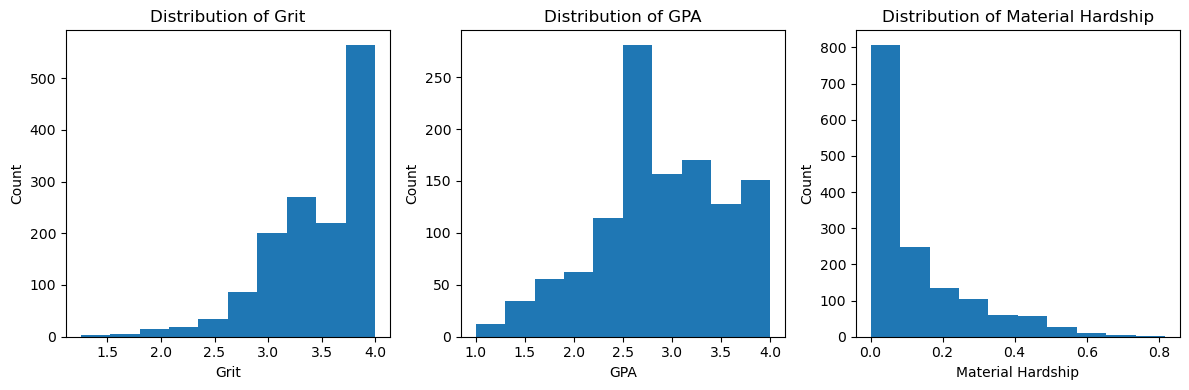

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the distribution of 'grit'
axs[0].hist(df_grit['grit'], bins=10)
axs[0].set_xlabel('Grit')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of Grit')

# Plot the distribution of 'gpa'
axs[1].hist(df_gpa['gpa'], bins=10)
axs[1].set_xlabel('GPA')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of GPA')

# Plot the distribution of 'materialHardship'
axs[2].hist(df_materialHardship['materialHardship'], bins=10)
axs[2].set_xlabel('Material Hardship')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of Material Hardship')

plt.tight_layout()
plt.show()

#### Step 12: Visualise distributions for categorical outcome variables

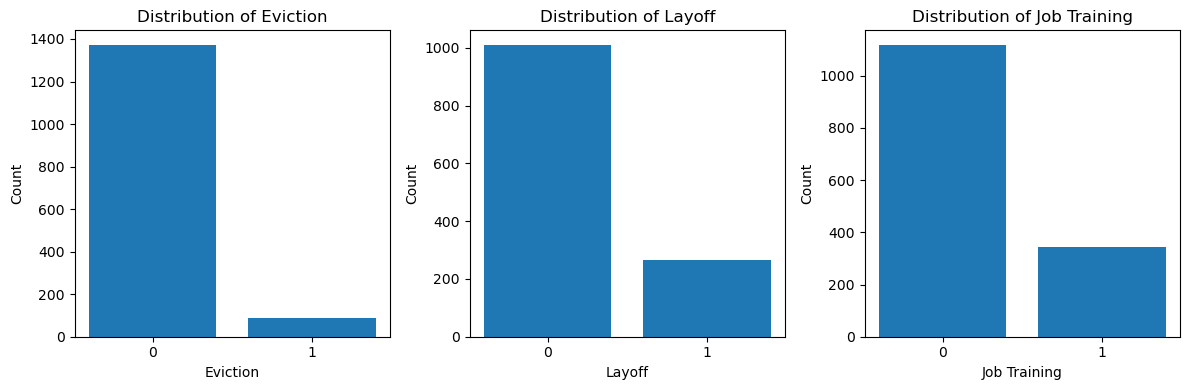

In [51]:
import matplotlib.pyplot as plt

# Plot the distributions of binary variables
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot for 'eviction'
axes[0].bar(df_eviction['eviction'].value_counts().index, df_eviction['eviction'].value_counts().values)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['0', '1'])
axes[0].set_xlabel('Eviction')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Eviction')

# Plot for 'layoff'
axes[1].bar(df_layoff['layoff'].value_counts().index, df_layoff['layoff'].value_counts().values)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])
axes[1].set_xlabel('Layoff')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Layoff')

# Plot for 'jobTraining'
axes[2].bar(df_jobTraining['jobTraining'].value_counts().index, df_jobTraining['jobTraining'].value_counts().values)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['0', '1'])
axes[2].set_xlabel('Job Training')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Job Training')

plt.tight_layout()
plt.show()


#### Step 13: Upsampling the categorical columns

In [52]:
from imblearn.over_sampling import RandomOverSampler

# Separate the features and target variable
X = df_eviction.drop(columns=['eviction'])
y = df_eviction['eviction']

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new dataframe with the resampled data
df_eviction_resampled = pd.concat([X_resampled, y_resampled], axis=1)


In [53]:
df_eviction_resampled['eviction'].value_counts()

eviction
0.0    1372
1.0    1372
Name: count, dtype: int64

In [54]:
# Separate the features and target variable
X = df_layoff.drop(columns=['layoff'])
y = df_layoff['layoff']

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new dataframe with the resampled data
df_layoff_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [55]:
df_layoff_resampled['layoff'].value_counts()

layoff
0.0    1010
1.0    1010
Name: count, dtype: int64

In [56]:
# Separate the features and target variable
X = df_jobTraining.drop(columns=['jobTraining'])
y = df_jobTraining['jobTraining']

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new dataframe with the resampled data
df_jobTraining_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [57]:
df_jobTraining_resampled ['jobTraining'].value_counts()

jobTraining
0.0    1118
1.0    1118
Name: count, dtype: int64

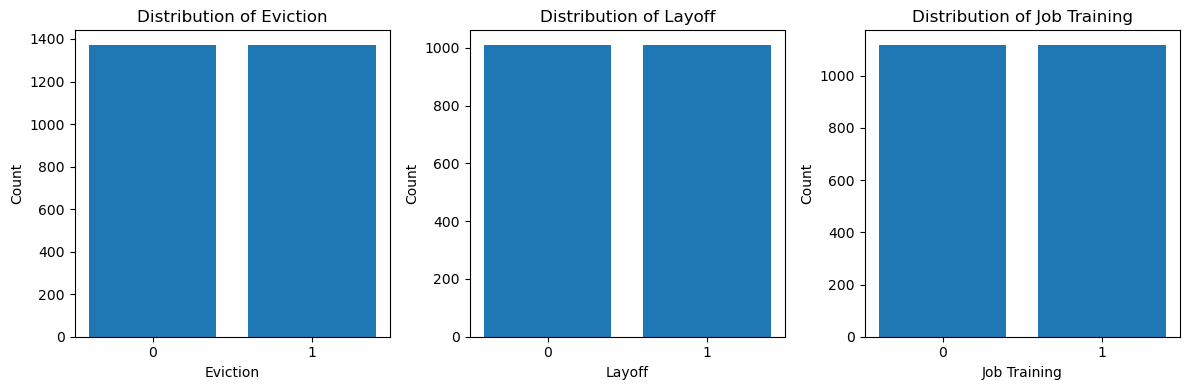

In [58]:
import matplotlib.pyplot as plt

# Plot the distributions of binary variables
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot for 'eviction'
axes[0].bar(df_eviction_resampled['eviction'].value_counts().index, df_eviction_resampled['eviction'].value_counts().values)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['0', '1'])
axes[0].set_xlabel('Eviction')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Eviction')

# Plot for 'layoff'
axes[1].bar(df_layoff_resampled['layoff'].value_counts().index, df_layoff_resampled['layoff'].value_counts().values)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])
axes[1].set_xlabel('Layoff')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Layoff')

# Plot for 'jobTraining'
axes[2].bar(df_jobTraining_resampled['jobTraining'].value_counts().index, df_jobTraining_resampled['jobTraining'].value_counts().values)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['0', '1'])
axes[2].set_xlabel('Job Training')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Job Training')

plt.tight_layout()
plt.show()


#### Step 14: Yeo-Johnson Transformation for continuous outcome variables

In [59]:
#Wanted to do a box cox tranformation but it cannot handle zero values. Thus, the Yeo-Johnson tranformation was used since material hardship has
# 0 values.

In [60]:
from sklearn.preprocessing import PowerTransformer

# Create a Yeo-Johnson transformer
transformer = PowerTransformer(method='yeo-johnson')

# Transform 'grit'
df_grit['grit'] = transformer.fit_transform(df_grit[['grit']])

# Transform 'gpa'
df_gpa['gpa'] = transformer.fit_transform(df_gpa[['gpa']])

# Transform 'materialHardship'
df_materialHardship['materialHardship'] = transformer.fit_transform(df_materialHardship[['materialHardship']])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


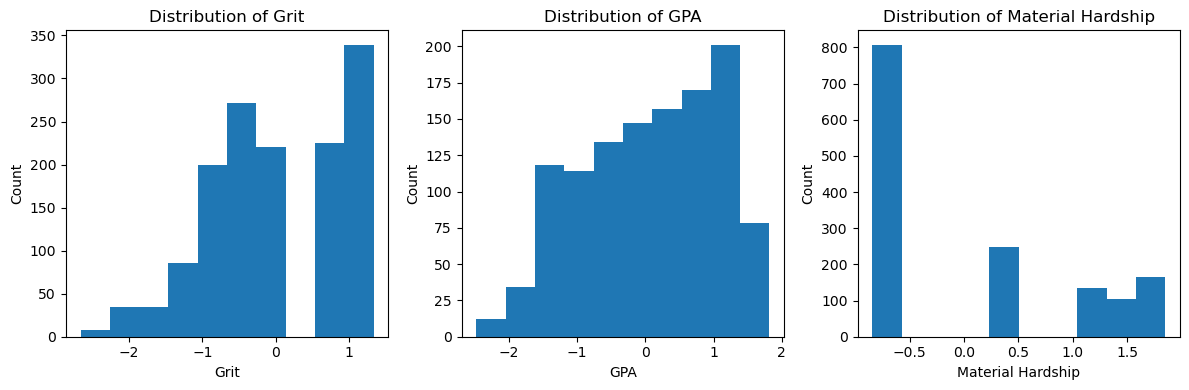

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the distribution of 'grit'
axs[0].hist(df_grit['grit'], bins=10)
axs[0].set_xlabel('Grit')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of Grit')

# Plot the distribution of 'gpa'
axs[1].hist(df_gpa['gpa'], bins=10)
axs[1].set_xlabel('GPA')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of GPA')

# Plot the distribution of 'materialHardship'
axs[2].hist(df_materialHardship['materialHardship'], bins=10)
axs[2].set_xlabel('Material Hardship')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of Material Hardship')

plt.tight_layout()
plt.show()

In [62]:
df_encoded

cf1lenmin  f1citywt    f1e1d1    f1e1d2    f1e1d3      f1j6      f1j8  \
0      0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
1      0.268663 -0.153814 -0.239923 -0.246741 -0.228188  0.519528  1.142958   
2      0.682495 -0.270578  1.028997  1.642285  0.925195 -0.308768 -0.385464   
3      0.682495 -0.345141 -0.874383 -0.246741 -0.228188 -0.308768 -0.385532   
4      1.096328 -0.272207  3.919315  1.886030  3.520308  1.347825 -0.347516   
...         ...       ...       ...       ...       ...       ...       ...   
4237   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4238   0.268663 -0.172847  0.606024 -0.124868 -0.228188 -0.722917 -0.377650   
4239   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
4240  -3.042000 -0.336954 -0.239923 -0.246741 -0.228188 -0.308768 -0.385110   
4241   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   

         f1j11     f1j12      f1k4  ...  cm5samp_5.0  cm5samp_6.0  \
0     0.522282 -0.317067 -0.137788  ...          0.0          1.0   
1     0.667379  0.517263  0.837701  ...          0.0          1.0   
2     0.667379 -0.317067  0.254060  ...          0.0          0.0   
3     0.522282 -0.317067 -0.057441  ...          0.0          1.0   
4    -1.654171  1.351593 -1.251722  ...          0.0          1.0   
...        ...       ...       ...  ...          ...          ...   
4237  0.522282 -0.317067 -0.137788  ...          0.0          0.0   
4238 -0.783590 -0.734232 -1.080309  ...          0.0          1.0   
4239  0.522282 -0.317067 -0.137788  ...          1.0          0.0   
4240 -1.218880 -0.317067  0.132004  ...          0.0          1.0   
4241  0.522282 -0.317067 -0.137788  ...          0.0          1.0   

      cm5samp_7.0  cf5samp_1.0  cf5samp_2.0  cf5samp_3.0  cf5samp_4.0  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          1.0          0.0          0.0          0.0   
2             1.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
4237          0.0          0.0          0.0          1.0          0.0   
4238          0.0          0.0          0.0          0.0          0.0   
4239          0.0          0.0          0.0          0.0          0.0   
4240          0.0          0.0          0.0          0.0          0.0   
4241          0.0          0.0          0.0          0.0          0.0   

      cf5samp_5.0  cf5samp_6.0  cf5samp_7.0  
0             0.0          1.0          0.0  
1             0.0          0.0          0.0  
2             0.0          0.0          1.0  
3             0.0          0.0          1.0  
4             0.0          0.0          1.0  
...           ...          ...          ...  
4237          0.0          0.0          0.0  
4238          0.0          0.0          1.0  
4239          0.0          1.0          0.0  
4240          0.0          0.0          1.0  
4241          0.0          0.0          1.0  

[4242 rows x 20093 columns]

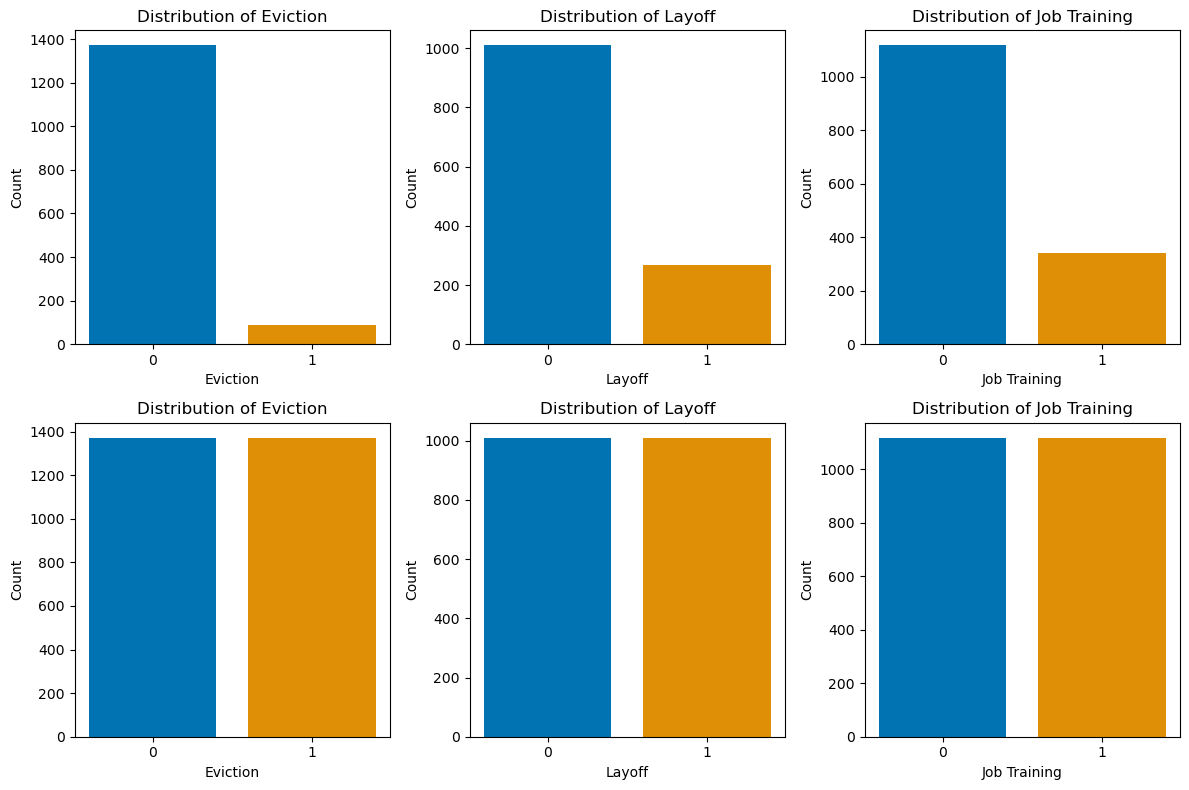

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for the bars
colors = sns.color_palette("colorblind")

# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot distributions of binary variables for the first dataset
axes[0, 0].bar(df_eviction['eviction'].value_counts().index, df_eviction['eviction'].value_counts().values, color=colors)
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['0', '1'])
axes[0, 0].set_xlabel('Eviction')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Eviction')

axes[0, 1].bar(df_layoff['layoff'].value_counts().index, df_layoff['layoff'].value_counts().values, color=colors)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['0', '1'])
axes[0, 1].set_xlabel('Layoff')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Layoff')

axes[0, 2].bar(df_jobTraining['jobTraining'].value_counts().index, df_jobTraining['jobTraining'].value_counts().values, color=colors)
axes[0, 2].set_xticks([0, 1])
axes[0, 2].set_xticklabels(['0', '1'])
axes[0, 2].set_xlabel('Job Training')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Distribution of Job Training')

# Plot distributions of binary variables for the second dataset
axes[1, 0].bar(df_eviction_resampled['eviction'].value_counts().index, df_eviction_resampled['eviction'].value_counts().values, color=colors)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['0', '1'])
axes[1, 0].set_xlabel('Eviction')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Eviction')

axes[1, 1].bar(df_layoff_resampled['layoff'].value_counts().index, df_layoff_resampled['layoff'].value_counts().values, color=colors)
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['0', '1'])
axes[1, 1].set_xlabel('Layoff')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Layoff')

axes[1, 2].bar(df_jobTraining_resampled['jobTraining'].value_counts().index, df_jobTraining_resampled['jobTraining'].value_counts().values, color=colors)
axes[1, 2].set_xticks([0, 1])
axes[1, 2].set_xticklabels(['0', '1'])
axes[1, 2].set_xlabel('Job Training')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Distribution of Job Training')

plt.tight_layout()
plt.show()


### Alternative Imputation for Outcome Vars

In [64]:
from sklearn.impute import SimpleImputer

# Select the columns for median imputation
cols_median = ['gpa', 'grit', 'materialHardship']

# Create a SimpleImputer object with median strategy
imputer_median = SimpleImputer(strategy='median')

# Fit the imputer on the train set
imputer_median.fit(train[cols_median])

# Impute the missing values in train using median strategy
train[cols_median] = imputer_median.transform(train[cols_median])


In [65]:
# Select the columns for median imputation
cols_mode = ['eviction', 'layoff', 'jobTraining']

# Create a SimpleImputer object with median strategy
imputer_mode = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the train set
imputer_mode.fit(train[cols_mode])

# Impute the missing values in train using median strategy
train[cols_mode] = imputer_mode.transform(train[cols_mode])

In [66]:
from imblearn.over_sampling import RandomOverSampler
# Separate the features and target variable for eviction
X_eviction = train.drop(columns=['eviction'])
y_eviction = train['eviction']

# Create an instance of RandomOverSampler for eviction
oversampler_eviction = RandomOverSampler(random_state=42)

# Resample the data for eviction
X_resampled_eviction, y_resampled_eviction = oversampler_eviction.fit_resample(X_eviction, y_eviction)

# Create a new dataframe with the resampled data for eviction
train_resampled_eviction = pd.concat([X_resampled_eviction, y_resampled_eviction], axis=1)

# Separate the features and target variable for layoff
X_layoff = train.drop(columns=['layoff'])
y_layoff = train['layoff']

# Create an instance of RandomOverSampler for layoff
oversampler_layoff = RandomOverSampler(random_state=42)

# Resample the data for layoff
X_resampled_layoff, y_resampled_layoff = oversampler_layoff.fit_resample(X_layoff, y_layoff)

# Create a new dataframe with the resampled data for layoff
train_resampled_layoff = pd.concat([X_resampled_layoff, y_resampled_layoff], axis=1)

# Separate the features and target variable for jobTraining
X_jobTraining = train.drop(columns=['jobTraining'])
y_jobTraining = train['jobTraining']

# Create an instance of RandomOverSampler for jobTraining
oversampler_jobTraining = RandomOverSampler(random_state=42)

# Resample the data for jobTraining
X_resampled_jobTraining, y_resampled_jobTraining = oversampler_jobTraining.fit_resample(X_jobTraining, y_jobTraining)

# Create a new dataframe with the resampled data for jobTraining
train_resampled_jobTraining = pd.concat([X_resampled_jobTraining, y_resampled_jobTraining], axis=1)


In [67]:
train_resampled_layoff['layoff'].value_counts()

layoff
0.0    1854
1.0    1854
Name: count, dtype: int64

In [68]:
train

challengeID   gpa  grit  materialHardship  eviction  layoff  jobTraining
0               1  3.00  3.50          0.000000       0.0     0.0          0.0
1               3  3.00  3.50          0.000000       0.0     0.0          0.0
2               6  3.00  3.50          0.090909       0.0     0.0          0.0
3               7  2.50  3.25          0.000000       0.0     0.0          0.0
4               8  3.00  3.50          0.000000       0.0     0.0          0.0
...           ...   ...   ...               ...       ...     ...          ...
2116         4235  3.00  3.50          0.000000       0.0     0.0          0.0
2117         4236  3.00  3.75          0.000000       0.0     0.0          0.0
2118         4239  2.75  2.75          0.000000       0.0     0.0          0.0
2119         4240  3.00  3.50          0.000000       0.0     0.0          0.0
2120         4241  3.00  4.00          0.000000       0.0     1.0          1.0

[2121 rows x 7 columns]

In [69]:
merged_df = df_encoded.merge(train, left_index=True, right_index=True)


In [70]:
merged_df

cf1lenmin  f1citywt    f1e1d1    f1e1d2    f1e1d3      f1j6      f1j8  \
0      0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
1      0.268663 -0.153814 -0.239923 -0.246741 -0.228188  0.519528  1.142958   
2      0.682495 -0.270578  1.028997  1.642285  0.925195 -0.308768 -0.385464   
3      0.682495 -0.345141 -0.874383 -0.246741 -0.228188 -0.308768 -0.385532   
4      1.096328 -0.272207  3.919315  1.886030  3.520308  1.347825 -0.347516   
...         ...       ...       ...       ...       ...       ...       ...   
2116  -0.145170 -0.317348 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
2117   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
2118   0.268663 -0.281746 -0.239923 -0.246741 -0.228188 -0.308768 -0.381812   
2119  -0.972836 -0.315035 -0.874383 -1.099849 -0.228188 -0.143109 -0.370516   
2120  -0.559003 -0.207057  1.099492  0.423559 -0.228188 -0.308768 -0.385464   

         f1j11     f1j12      f1k4  ...  cf5samp_5.0  cf5samp_6.0  \
0     0.522282 -0.317067 -0.137788  ...          0.0          1.0   
1     0.667379  0.517263  0.837701  ...          0.0          0.0   
2     0.667379 -0.317067  0.254060  ...          0.0          0.0   
3     0.522282 -0.317067 -0.057441  ...          0.0          0.0   
4    -1.654171  1.351593 -1.251722  ...          0.0          0.0   
...        ...       ...       ...  ...          ...          ...   
2116  0.522282 -0.317067 -0.137788  ...          0.0          0.0   
2117  0.522282 -0.317067 -0.137788  ...          0.0          0.0   
2118  0.522282 -0.317067 -0.137788  ...          0.0          0.0   
2119  0.667379 -0.150201 -1.141397  ...          0.0          0.0   
2120  0.667379 -0.317067 -0.682478  ...          0.0          0.0   

      cf5samp_7.0  challengeID   gpa  grit  materialHardship  eviction  \
0             0.0            1  3.00  3.50          0.000000       0.0   
1             0.0            3  3.00  3.50          0.000000       0.0   
2             1.0            6  3.00  3.50          0.090909       0.0   
3             1.0            7  2.50  3.25          0.000000       0.0   
4             1.0            8  3.00  3.50          0.000000       0.0   
...           ...          ...   ...   ...               ...       ...   
2116          1.0         4235  3.00  3.50          0.000000       0.0   
2117          1.0         4236  3.00  3.75          0.000000       0.0   
2118          1.0         4239  2.75  2.75          0.000000       0.0   
2119          1.0         4240  3.00  3.50          0.000000       0.0   
2120          1.0         4241  3.00  4.00          0.000000       0.0   

      layoff  jobTraining  
0        0.0          0.0  
1        0.0          0.0  
2        0.0          0.0  
3        0.0          0.0  
4        0.0          0.0  
...      ...          ...  
2116     0.0          0.0  
2117     0.0          0.0  
2118     0.0          0.0  
2119     0.0          0.0  
2120     1.0          1.0  

[2121 rows x 20100 columns]

### Baseline Models

#### GPA

In [71]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

##### With Train Data Imputation

In [74]:
X = merged_df.drop(['gpa','grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'], axis=1)
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [75]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 20093)
X_val shape: (325, 20093)
X_test shape: (319, 20093)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [72]:
from sklearn.tree import DecisionTreeRegressor


In [74]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()
decision_tree = DecisionTreeRegressor()

models = [lr, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train['gpa'])

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val['gpa'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val['gpa'], predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")

LinearRegression Mean Squared Error: 0.40216456542361284
LinearRegression Root Mean Squared Error (RMSE): 0.6341644624414181
LinearRegression R-squared: -0.4388683864837233
############################################
Lasso Mean Squared Error: 0.27975913788342593
Lasso Root Mean Squared Error (RMSE): 0.5289226199392743
Lasso R-squared: -0.0009250290522184734
############################################
ElasticNet Mean Squared Error: 0.27975913788342593
ElasticNet Root Mean Squared Error (RMSE): 0.5289226199392743
ElasticNet R-squared: -0.0009250290522184734
############################################
RandomForestRegressor Mean Squared Error: 0.28774892307692307
RandomForestRegressor Root Mean Squared Error (RMSE): 0.5364223364821072
RandomForestRegressor R-squared: -0.02951096207098014
############################################
GradientBoostingRegressor Mean Squared Error: 0.3032770257346711
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.5507059339926084
GradientBoostin

#### Grit

##### With Train Data Imputation

In [75]:
for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train['grit'])

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val['grit'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val['grit'], predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")

LinearRegression Mean Squared Error: 0.25007029235987643
LinearRegression Root Mean Squared Error (RMSE): 0.5000702874195551
LinearRegression R-squared: -0.5690553937618943
############################################
Lasso Mean Squared Error: 0.15946920309280607
Lasso Root Mean Squared Error (RMSE): 0.3993359526674327
Lasso R-squared: -0.0005827197242291859
############################################
ElasticNet Mean Squared Error: 0.15946920309280607
ElasticNet Root Mean Squared Error (RMSE): 0.3993359526674327
ElasticNet R-squared: -0.0005827197242291859
############################################
RandomForestRegressor Mean Squared Error: 0.15683386538461536
RandomForestRegressor Root Mean Squared Error (RMSE): 0.39602255666137925
RandomForestRegressor R-squared: 0.015952594432440237
############################################
GradientBoostingRegressor Mean Squared Error: 0.16795053142149768
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.40981768070874847
GradientBoos

#### Material Hardship

##### With Train Data Imputation

In [76]:
for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train['materialHardship'])

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val['materialHardship'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val['materialHardship'], predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")

LinearRegression Mean Squared Error: 0.03156261473336521
LinearRegression Root Mean Squared Error (RMSE): 0.17765870294856148
LinearRegression R-squared: -0.6292922173572635
############################################
Lasso Mean Squared Error: 0.01941001690172446
Lasso Root Mean Squared Error (RMSE): 0.13931983671295506
Lasso R-squared: -0.0019635490884057916
############################################
ElasticNet Mean Squared Error: 0.01941001690172446
ElasticNet Root Mean Squared Error (RMSE): 0.13931983671295506
ElasticNet R-squared: -0.0019635490884057916
############################################
RandomForestRegressor Mean Squared Error: 0.02224673871582964
RandomForestRegressor Root Mean Squared Error (RMSE): 0.1491534066517746
RandomForestRegressor R-squared: -0.14839782944108304
############################################
GradientBoostingRegressor Mean Squared Error: 0.021453921533290662
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.1464715724408346
GradientBo

#### Eviction

##### With Train Data Imputation

In [77]:
df_eviction_merged = df_encoded.merge(train_resampled_eviction['eviction'], left_index=True, right_index=True)

In [78]:
X = df_eviction_merged.drop(['eviction'], axis=1)
y = df_eviction_merged['eviction']

In [79]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2834, 20093)
X_val shape: (623, 20093)
X_test shape: (611, 20093)
Y_train shape: (2834,)
Y_val shape: (623,)
Y_test shape: (611,)


In [73]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import ConvergenceWarning
import warnings

# Create model objects
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [81]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5200642054574639
LogisticRegression Precision: 0.5457413249211357
LogisticRegression Recall: 0.5274390243902439
LogisticRegression F1-score: 0.5364341085271318
############################################
DecisionTreeClassifier Accuracy: 0.5441412520064205
DecisionTreeClassifier Precision: 0.5718954248366013
DecisionTreeClassifier Recall: 0.5335365853658537
DecisionTreeClassifier F1-score: 0.5520504731861199
############################################
RandomForestClassifier Accuracy: 0.492776886035313
RandomForestClassifier Precision: 0.5189873417721519
RandomForestClassifier Recall: 0.5
RandomForestClassifier F1-score: 0.5093167701863354
############################################
GradientBoostingClassifier Accuracy: 0.5232744783306581
GradientBoostingClassifier Precision: 0.5504885993485342
GradientBoostingClassifier Recall: 0.5152439024390244
GradientBoostingClassifier F1-score: 0.5322834645669291
############################################


#### Job Training

##### With Train Data Imputation

In [82]:
X = merged_df.drop(['gpa','grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'], axis=1)
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [83]:
df_jobTraining_merged = df_encoded.merge(train_resampled_jobTraining['jobTraining'], left_index=True, right_index=True)

In [84]:
X = df_jobTraining_merged.drop(['jobTraining'], axis=1)
y = df_jobTraining_merged['jobTraining']

In [85]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2478, 20093)
X_val shape: (544, 20093)
X_test shape: (534, 20093)
Y_train shape: (2478,)
Y_val shape: (544,)
Y_test shape: (534,)


In [86]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.48713235294117646
LogisticRegression Precision: 0.5019157088122606
LogisticRegression Recall: 0.46785714285714286
LogisticRegression F1-score: 0.48428835489833644
############################################
DecisionTreeClassifier Accuracy: 0.49264705882352944
DecisionTreeClassifier Precision: 0.5077519379844961
DecisionTreeClassifier Recall: 0.46785714285714286
DecisionTreeClassifier F1-score: 0.48698884758364314
############################################
RandomForestClassifier Accuracy: 0.47794117647058826
RandomForestClassifier Precision: 0.493006993006993
RandomForestClassifier Recall: 0.5035714285714286
RandomForestClassifier F1-score: 0.49823321554770317
############################################
GradientBoostingClassifier Accuracy: 0.5110294117647058
GradientBoostingClassifier Precision: 0.5253623188405797
GradientBoostingClassifier Recall: 0.5178571428571429
GradientBoostingClassifier F1-score: 0.5215827338129496
##############################

#### Layoff

##### With Train Data Imputation

In [87]:
df_layoff_merged =  df_encoded.merge(train_resampled_layoff['layoff'], left_index=True, right_index=True)

In [88]:
X = df_layoff_merged.drop(['layoff'], axis=1)
y = df_layoff_merged['layoff']

In [89]:
df_layoff_merged['layoff'].value_counts()

layoff
0.0    1854
1.0    1854
Name: count, dtype: int64

In [90]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2583, 20093)
X_val shape: (568, 20093)
X_test shape: (557, 20093)
Y_train shape: (2583,)
Y_val shape: (568,)
Y_test shape: (557,)


In [91]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5211267605633803
LogisticRegression Precision: 0.5451388888888888
LogisticRegression Recall: 0.5268456375838926
LogisticRegression F1-score: 0.5358361774744027
############################################
DecisionTreeClassifier Accuracy: 0.4982394366197183
DecisionTreeClassifier Precision: 0.5228070175438596
DecisionTreeClassifier Recall: 0.5
DecisionTreeClassifier F1-score: 0.5111492281303602
############################################
RandomForestClassifier Accuracy: 0.4894366197183099
RandomForestClassifier Precision: 0.5147058823529411
RandomForestClassifier Recall: 0.4697986577181208
RandomForestClassifier F1-score: 0.49122807017543857
############################################
GradientBoostingClassifier Accuracy: 0.47183098591549294
GradientBoostingClassifier Precision: 0.49645390070921985
GradientBoostingClassifier Recall: 0.4697986577181208
GradientBoostingClassifier F1-score: 0.4827586206896552
############################################


### Feature Selection - GPA

#### LASSO

##### With Train Data Imputation

In [72]:
from sklearn.tree import DecisionTreeRegressor


In [73]:
from sklearn.linear_model import Lasso
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [74]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()
decision_tree = DecisionTreeRegressor()

models = [lr, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]


In [75]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 20093)
X_val shape: (325, 20093)
X_test shape: (319, 20093)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [83]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a Lasso regressor
lasso = Lasso()

# Create the GridSearchCV object
grid = GridSearchCV(lasso, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.341e-02, tolerance: 2.815e-02


Best parameters: {'alpha': 0.1}
Best score: -0.1190210857513154


In [96]:
# lasso = Lasso(alpha=0.1)

In [76]:
from sklearn.linear_model import Lasso

# Create a Lasso regressor with the best alpha
lasso = Lasso(alpha=0.01)

# Fit the model to the data
lasso.fit(X_train, y_train['gpa'])

# Print the coefficients
print(f'Coefficients: {lasso.coef_}')

Coefficients: [-0.  0. -0. ... -0.  0. -0.]


In [77]:
# # Fit the Lasso model
# lasso.fit(X, y['gpa'])

In [78]:
# Get the coefficients of the features
feature_coefficients = pd.Series(lasso.coef_, index=X.columns)

# Select the features with non-zero coefficients
lasso_selected_features = feature_coefficients[feature_coefficients != 0].index

# Print the selected features
print(lasso_selected_features)

Index(['cf1hhinc', 'cm1lenmin', 'm1e1d1', 'm1citywt_rep1', 'f2l1',
       'f2citywt_rep5', 'm2g5b_a1', 'm2k9', 'cm2povco', 'f3f2c2',
       ...
       'p5i23_5.0', 'p5j2a_1.0', 'p5m2b_1.0', 'p5q1g_8.0', 'p5q3bu_1.0',
       'p5q3cf_2.0', 't5b3l_1.0', 't5b4z_0.0', 't5d7_3.0', 't5d8b_2.0'],
      dtype='object', length=131)


In [79]:
# y_train = np.ravel(y_train)
# y_test = np.ravel(y_test)

In [80]:
len(lasso_selected_features)

131

In [81]:
from sklearn.linear_model import LinearRegression
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]


In [82]:
# Create the feature matrix X using the selected features
X = X[lasso_selected_features]

# Create the target variable y
y = y['gpa']

In [83]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 131)
X_val shape: (325, 131)
X_test shape: (319, 131)
Y_train shape: (1477,)
Y_val shape: (325,)
Y_test shape: (319,)


In [84]:
for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")


LinearRegression Mean Squared Error: 0.33353577486884134
LinearRegression Root Mean Squared Error (RMSE): 0.5775255620912735
LinearRegression R-squared: -0.19332761630706874
############################################
Lasso Mean Squared Error: 0.27975913788342593
Lasso Root Mean Squared Error (RMSE): 0.5289226199392743
Lasso R-squared: -0.0009250290522184734
############################################
ElasticNet Mean Squared Error: 0.27975913788342593
ElasticNet Root Mean Squared Error (RMSE): 0.5289226199392743
ElasticNet R-squared: -0.0009250290522184734
############################################


RandomForestRegressor Mean Squared Error: 0.2944891538461539
RandomForestRegressor Root Mean Squared Error (RMSE): 0.5426685487902849
RandomForestRegressor R-squared: -0.053626226828917156
############################################
GradientBoostingRegressor Mean Squared Error: 0.29233686848293944
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.5406818551449082
GradientBoostingRegressor R-squared: -0.04592575882632488
############################################
XGBRegressor Mean Squared Error: 0.33248917149271673
XGBRegressor Root Mean Squared Error (RMSE): 0.5766187401504713
XGBRegressor R-squared: -0.18958306832704808
############################################
DecisionTreeRegressor Mean Squared Error: 0.5244230769230769
DecisionTreeRegressor Root Mean Squared Error (RMSE): 0.7241706131313786
DecisionTreeRegressor R-squared: -0.8762861062419021
############################################


In [86]:
# Fit the LASSO model
lasso = Lasso(alpha=0.01)  # replace best_alpha with the alpha value you used
lasso.fit(X_train, y_train)

# Get the coefficients
coefficients = lasso.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': lasso_selected_features, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients in descending order
features_df = features_df.reindex(features_df.Coefficient.abs().sort_values(ascending=False).index)

# Get the top 5 most informative features
top_5_features = features_df.head(5)

print(top_5_features)

        Feature  Coefficient
21     cf4povco    -0.040593
80   m3k16b_3.0     0.038487
106   p4l36_0.0    -0.036737
60   f2b38d_4.0     0.036316
90    f4c3h_7.0    -0.035657


#### Elastic Net

In [87]:
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel

In [88]:
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa']]

In [108]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

# Create an ElasticNet regressor
elastic_net = ElasticNet()

# Create the GridSearchCV object
grid = GridSearchCV(elastic_net, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.023e+00, tolerance: 4.333e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e+00, tolerance: 4.178e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e+00, tolerance: 4.145e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e+00, tolerance: 4.030e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e+00, tolerance: 4.295e-02
Objective did n

Best parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Best score: -0.2474440785254564


In [110]:
# from sklearn.linear_model import ElasticNet

# # Assuming X and y are your features and target variables
# # Create an ElasticNet model
# elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5)

# # Fit the model
# elastic_net.fit(X, y)

# # Get the coefficients
# coef = elastic_net.coef_

# # Get the indices of the features selected by ElasticNet
# selected_features_indices = np.where(coef != 0)[0]

# # Get the names of the selected features
# selected_features_names = X.columns[selected_features_indices]

# print(f"The selected features are: {selected_features_names}")

In [91]:
from sklearn.linear_model import ElasticNet

# Assuming X and y are your features and target variables
# Create an ElasticNet model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit the model
elastic_net.fit(X_train, y_train)

# Get the coefficients
coef = elastic_net.coef_

# Get the indices of the features selected by ElasticNet
selected_features_indices = np.where(coef != 0)[0]

# Get the names of the selected features
selected_features_names = X.columns[selected_features_indices]

print(f"The selected features are: {selected_features_names}")

The selected features are: Index(['cf1lenmin', 'f1citywt', 'f1e1d1', 'f1e1d2', 'f1e1d3', 'f1j6', 'f1j8',
       'f1j11', 'f1j12', 'f1k4',
       ...
       'f3k20', 'f3l1', 'f3l2a', 'f3l6b', 'f3l6c', 'cf3hhinc', 'cf3hhincb',
       'cf3povco', 'cf3povcob', 'f3citywt_rep1'],
      dtype='object', length=131)


In [92]:
len(selected_features_names)

131

In [93]:
# Create the feature matrix X using the selected features
X = X[selected_features_names]

# Create the target variable y
# y = y['gpa']

In [94]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 131)
X_val shape: (325, 131)
X_test shape: (319, 131)
Y_train shape: (1477, 1)
Y_val shape: (325, 1)
Y_test shape: (319, 1)


In [95]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()
decision_tree = DecisionTreeRegressor()

models = [lr, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")

LinearRegression Mean Squared Error: 0.29625333679482896
LinearRegression Root Mean Squared Error (RMSE): 0.5442915916995493
LinearRegression R-squared: -0.059938138148474485
############################################
Lasso Mean Squared Error: 0.27975913788342593
Lasso Root Mean Squared Error (RMSE): 0.5289226199392743
Lasso R-squared: -0.0009250290522184734
############################################


ElasticNet Mean Squared Error: 0.27975913788342593
ElasticNet Root Mean Squared Error (RMSE): 0.5289226199392743
ElasticNet R-squared: -0.0009250290522184734
############################################


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor Mean Squared Error: 0.2770303269230769
RandomForestRegressor Root Mean Squared Error (RMSE): 0.526336704898183
RandomForestRegressor R-squared: 0.008838137972207671
############################################


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor Mean Squared Error: 0.2841212424396794
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.5330302453329261
GradientBoostingRegressor R-squared: -0.016531810166607652
############################################
XGBRegressor Mean Squared Error: 0.31399830494979036
XGBRegressor Root Mean Squared Error (RMSE): 0.5603555165694278
XGBRegressor R-squared: -0.12342626189811412
############################################
DecisionTreeRegressor Mean Squared Error: 0.5571153846153846
DecisionTreeRegressor Root Mean Squared Error (RMSE): 0.7464016242046801
DecisionTreeRegressor R-squared: -0.993252970217378
############################################


In [97]:
from sklearn.linear_model import ElasticNet

# Fit the Elastic Net model
enet = ElasticNet(alpha=0.1, l1_ratio=0.1)  # replace best_alpha and best_l1_ratio with the values you used
enet.fit(X_train, y_train)

# Get the coefficients
coefficients = enet.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients in descending order
features_df = features_df.reindex(features_df.Coefficient.abs().sort_values(ascending=False).index)

# Get the top 5 most informative features
top_5_features = features_df.head(5)

print(top_5_features)

      Feature  Coefficient
87   m2g5b_a1     0.020769
49       f2l1    -0.010465
114    f3f2c2    -0.009004
128  cf3povco     0.008534
99   cm2povco     0.007776


In [117]:
# 89  p5i22a_1.0    -0.023611
# 55   m2c33_2.0     0.021490
# 72   p3c1a_3.0    -0.020085
# 25   ch5wj10ss    -0.019394
# 91  p5q3bu_1.0     0.018773

# Hyperparameter Tuning

#### LASSO

In [127]:
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df['gpa']

In [128]:
X = X[lasso_selected_features]

In [129]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 131)
X_val shape: (325, 131)
X_test shape: (319, 131)
Y_train shape: (1477,)
Y_val shape: (325,)
Y_test shape: (319,)


In [130]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [131]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
linear_regression = LinearRegression()

# Fit the model to the training data
linear_regression.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = linear_regression.predict(X_test)

# Compute the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.29380449741424813
Root Mean Squared Error: 0.5420373579507672
R^2 Score: -0.20476255945404187


##### Ridge

In [121]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a Ridge regressor
ridge = Ridge()

# Create the GridSearchCV object
grid = GridSearchCV(ridge, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'alpha': 100}
Best score: -0.2245999551978167


In [122]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Get the best parameters
best_params = grid.best_params_

# Create a Ridge regressor with the best parameters
ridge = Ridge(alpha = 100)

# Fit the model to the data
ridge.fit(X, y)

# Make predictions
y_pred = ridge.predict(X)

# Compute the Mean Absolute Error
mae = mean_absolute_error(y, y_pred)

# Compute the Mean Squared Error
mse = mean_squared_error(y, y_pred)

rmse = sqrt(mean_squared_error(y, y_pred))

# Compute the R^2 score
r2 = r2_score(y, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 0.3212150333359614
Mean Squared Error: 0.2001218180834604
Root Mean Squared Error: 0.4473497715249896
R^2 Score: 0.1908508674845809


##### Elastic Net

In [122]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

# Create an ElasticNet regressor
elastic_net = ElasticNet()

# Create the GridSearchCV object
grid = GridSearchCV(elastic_net, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Best score: -0.2263386485378316


In [123]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Get the best parameters
best_params = grid.best_params_

# Create an ElasticNet regressor with the best parameters
elastic_net = ElasticNet(**best_params)

# Fit the model to the data
elastic_net.fit(X, y)

# Make predictions
y_pred = elastic_net.predict(X)

# Compute the Mean Squared Error
mse = mean_squared_error(y, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.19880666004398134
Root Mean Squared Error: 0.44587740472464105
R^2 Score: 0.19616842354596642


##### Decision Tree

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the parameter grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
dt = DecisionTreeRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_sa

In [ ]:
# Decision Tree Best parameters:  {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}

In [134]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

dt = DecisionTreeRegressor(**best_params)

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Compute the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.2551920062695925
Root Mean Squared Error: 0.5051653256802099
R^2 Score: -0.0464297767099342


##### Random Forest

In [135]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 131)
X_val shape: (325, 131)
X_test shape: (319, 131)
Y_train shape: (1477,)
Y_val shape: (325,)
Y_test shape: (319,)


In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create a RandomForestRegressor
rf = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters are: {best_params}")

The best parameters are: {'max_depth': 30, 'min_samples_leaf': 6, 'min_samples_split': 20, 'n_estimators': 200}


In [138]:
# Create a Random Forest regressor with the best parameters
rf = RandomForestRegressor(**best_params)

# Fit the model to the data
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=6, min_samples_split=20,
                      n_estimators=200)

In [127]:
# rf = RandomForestRegressor(**best_params)

# # Fit the model to the data
# rf.fit(X, y)

In [128]:
#(max_depth=10, min_samples_leaf=4, min_samples_split=5,n_estimators=200)

In [139]:
predictions = rf.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

In [140]:
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.2505329308850465
Root Mean Squared Error (RMSE): 0.5005326471720366
R-squared: -0.027324965060095074


In [142]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

cv = KFold(n_splits=5, shuffle=True, random_state=42) 

scores = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor(max_depth=30, min_samples_leaf=6, min_samples_split=20,n_estimators=200) # Train your model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    scores.append(mse)

print(f"Mean MSE across folds: {np.mean(scores)}")


Mean MSE across folds: 0.2446381598605941


In [143]:
import shap

# Create a RandomForestRegressor with the best parameters
rf = RandomForestRegressor(max_depth=30, min_samples_leaf=6, min_samples_split=20, n_estimators=200)

# Fit the model to the data
rf.fit(X, y)

# Create a TreeExplainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

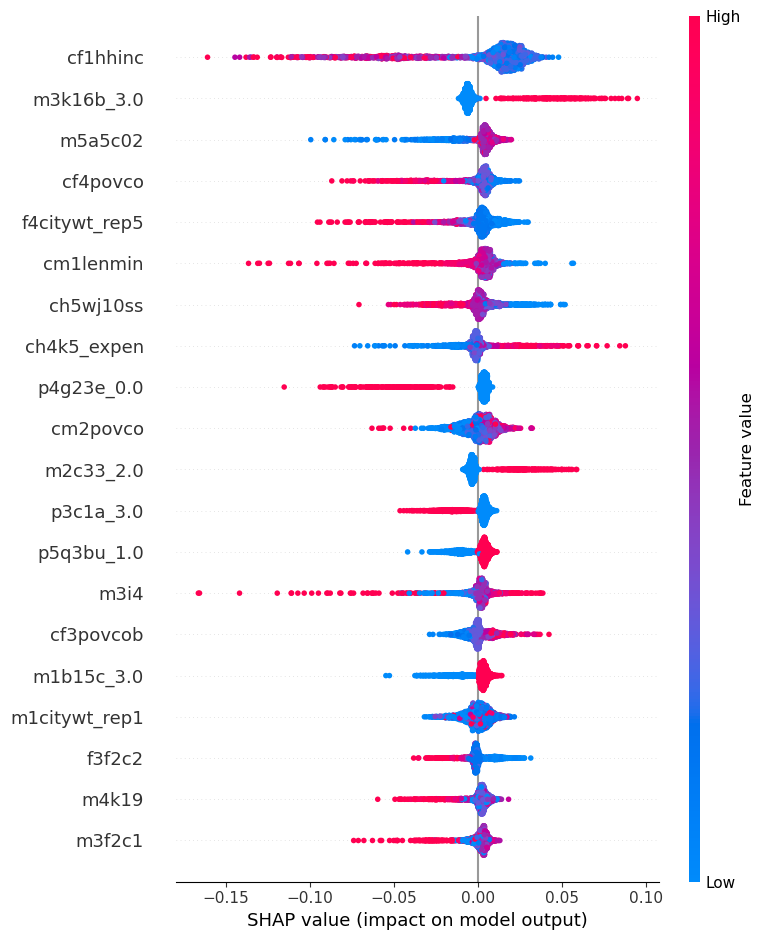

In [148]:

# Plot the SHAP values
shap.summary_plot(shap_values, X)

##### LIME

In [145]:
X_val.columns

Index(['cf1hhinc', 'cm1lenmin', 'm1e1d1', 'm1citywt_rep1', 'f2l1',
       'f2citywt_rep5', 'm2g5b_a1', 'm2k9', 'cm2povco', 'f3f2c2',
       ...
       'p5i23_5.0', 'p5j2a_1.0', 'p5m2b_1.0', 'p5q1g_8.0', 'p5q3bu_1.0',
       'p5q3cf_2.0', 't5b3l_1.0', 't5b4z_0.0', 't5d7_3.0', 't5d8b_2.0'],
      dtype='object', length=131)

In [146]:
from lime import lime_tabular

# Create a LimeTabularExplainer
explainer = lime_tabular.LimeTabularExplainer(X_train.values, 
                                              feature_names=X_train.columns, 
                                              class_names=['target'], 
                                              verbose=True, 
                                              mode='regression')

# Get the explanation for the first instance in the test set
exp = explainer.explain_instance(X_test.values[0], rf.predict, num_features=15)

# Visualize the explanation
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Intercept 2.95135534470475
Prediction_local [2.87400099]
Right: 2.921539104888331


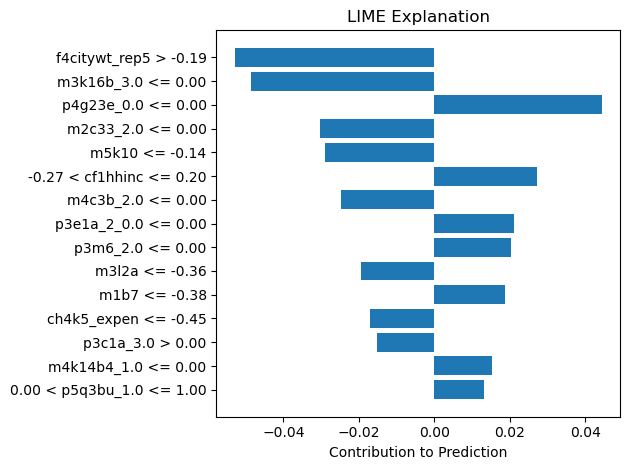

In [147]:
import matplotlib.pyplot as plt

# Get the explanation as a list of tuples
explanation = exp.as_list()

# Separate the features and their contributions
features, contributions = zip(*explanation)

# Create a bar plot
plt.barh(features, contributions)
plt.xlabel('Contribution to Prediction')
plt.title('LIME Explanation')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest contribution at the top
plt.tight_layout()

# Save the figure
plt.savefig('/Users/Applied Machine Learning/Summative/lime_explanation.png')

##### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Gradient Boosting regressor
gb = GradientBoostingRegressor()

# Create the GridSearchCV object
grid = GridSearchCV(gb, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [ ]:
#Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400, 'subsample': 0.5}
#Best score: -0.2391229402687649

In [152]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


# Create a Gradient Boosting regressor with the best parameters
gb = GradientBoostingRegressor(**grid.best_params_)

# Fit the model to the data
gb.fit(X_train, y_train)

# Make predictions
y_pred = gb.predict(X_test)

# Compute the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.23640705218886068
Root Mean Squared Error: 0.48621708339882574
R^2 Score: 0.0018699718780795793


## Elastic Net

In [98]:
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df['gpa']

In [99]:
X = X[selected_features_names]

In [100]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 131)
X_val shape: (325, 131)
X_test shape: (319, 131)
Y_train shape: (1477,)
Y_val shape: (325,)
Y_test shape: (319,)


In [101]:
len(X)

2121

##### Random Forest 

In [102]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create a RandomForestRegressor
rf = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters are: {best_params}")

The best parameters are: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 200}


In [143]:
# best_params = {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 400}

In [121]:
best_params = {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 200}

In [103]:
rf = RandomForestRegressor(**best_params)

# Fit the model to the data
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=15,
                      n_estimators=200)

In [104]:
predictions = rf.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

In [105]:
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.2447934168625572
Root Mean Squared Error (RMSE): 0.49476602234041617
R-squared: -0.0037897514584896985


In [106]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

cv = KFold(n_splits=5, shuffle=True, random_state=42) 

scores = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor(**best_params) # Train your model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    scores.append(mse)

print(f"Mean MSE across folds: {np.mean(scores)}")


Mean MSE across folds: 0.25160049487925223


In [122]:
import shap

# Create a RandomForestRegressor with the best parameters
rf = RandomForestRegressor(**best_params)

# Fit the model to the data
rf.fit(X_train, y_train)

# Create a TreeExplainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

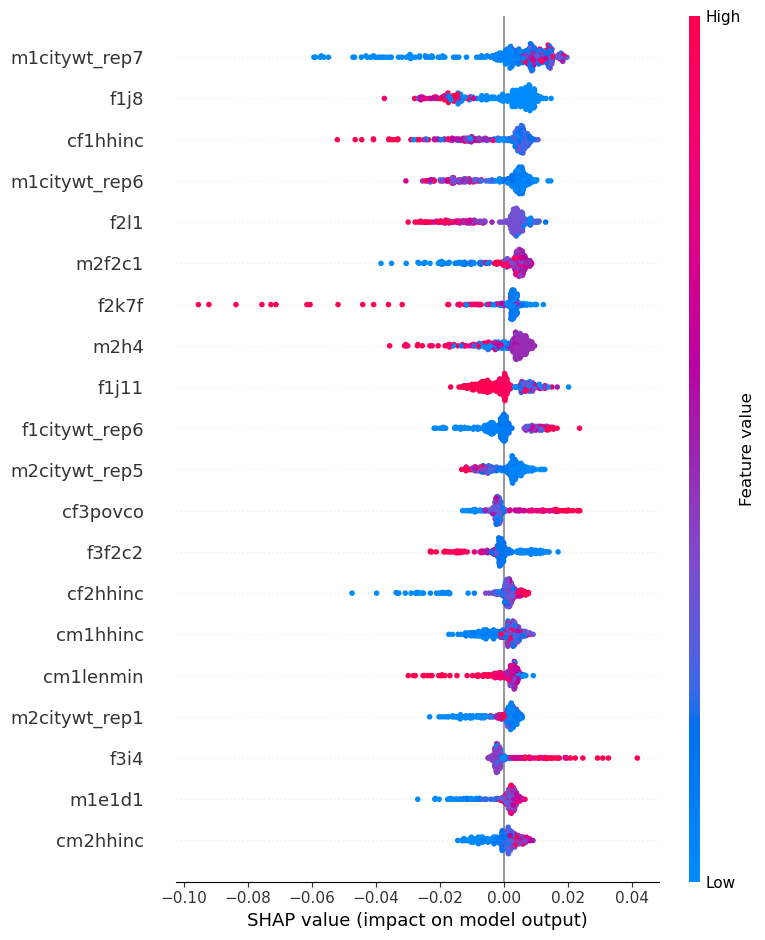

In [125]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_test)

In [131]:
# Get the feature names
feature_names = X_test.columns.tolist()

# Get the SHAP values for the first prediction
first_pred_shap_values = shap_values[0]

# Create a list of tuples with feature names and their corresponding SHAP values
feature_shap_list = list(zip(feature_names, first_pred_shap_values))

# Sort the list in descending order by the SHAP values
feature_shap_list.sort(key=lambda x: x[1], reverse=True)

feature_shap_list[:25]

[('f2citywt_rep1', 0.010467051783083518),
 ('m1citywt_rep7', 0.008232384669727458),
 ('f1j8', 0.006836810909497619),
 ('m2f2c1', 0.0063708482464751685),
 ('f3j2h', 0.006336431752107998),
 ('q2citywt_rep2', 0.005407409980946308),
 ('cm2hhinc', 0.00484347968936086),
 ('f1e1d3', 0.004518454922473947),
 ('cm1hhinc', 0.004239649754308346),
 ('f2l1', 0.0032861705180344813),
 ('m1e1d1', 0.003000774537747795),
 ('f2k15a', 0.0029291204462815394),
 ('m1citywt_rep10', 0.0028241680807587293),
 ('m2f2c2', 0.00272720735656617),
 ('m1citywt_rep6', 0.0025509866680040096),
 ('m2h4', 0.0024255171604806013),
 ('q2citywt_rep9', 0.0023702082036270453),
 ('f3k10', 0.002263864556027139),
 ('f3l2a', 0.002241346226852558),
 ('m1j2b', 0.0019955450354447405),
 ('m1citywt_rep5', 0.0019849236799703985),
 ('m1citywt_rep1', 0.001828966470685665),
 ('m2citywt_rep2', 0.0017831017359503654),
 ('cf2povcob', 0.0016349197921000952),
 ('m2k9', 0.0016184017037645117)]

In [133]:
import numpy as np

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Create a list of tuples with feature names and their corresponding mean absolute SHAP values
feature_shap_list = list(zip(X_test.columns, mean_abs_shap_values))

# Sort the list in descending order by the mean absolute SHAP values
feature_shap_list.sort(key=lambda x: x[1], reverse=True)

feature_shap_list

[('m1citywt_rep7', 0.01156453977498372),
 ('f1j8', 0.008769171948594797),
 ('cf1hhinc', 0.008358420522764268),
 ('m1citywt_rep6', 0.007206733366781357),
 ('f2l1', 0.006875400909784501),
 ('m2f2c1', 0.0062220248920180675),
 ('f2k7f', 0.006038964121239948),
 ('m2h4', 0.00600675478813926),
 ('f1j11', 0.0051457334649050975),
 ('f1citywt_rep6', 0.004901214804127501),
 ('m2citywt_rep5', 0.004620368383986655),
 ('cf3povco', 0.004200556999810554),
 ('f3f2c2', 0.004198340315642953),
 ('cf2hhinc', 0.004190669016513019),
 ('cm1hhinc', 0.0040938736375346636),
 ('cm1lenmin', 0.0039044787426164534),
 ('m2citywt_rep1', 0.003860120594948537),
 ('f3i4', 0.003675469192459552),
 ('m1e1d1', 0.0035204331610094912),
 ('cm2hhinc', 0.003517980484105777),
 ('m1citywt_rep3', 0.003514012118666563),
 ('m1j2a', 0.003507806066040213),
 ('m2citywt_rep9', 0.0031534560183926964),
 ('m1citywt_rep8', 0.003091113141438495),
 ('m1j2b', 0.0030502788529950275),
 ('m1i2b', 0.003020225403209022),
 ('m2k9', 0.00301864133041468

In [139]:
# Get the feature names
feature_names = X_test.columns.tolist()

# Get the SHAP values for the first prediction
first_pred_shap_values = shap_values[0]

# Create a list of tuples with feature names and their corresponding SHAP values
feature_shap_list = list(zip(feature_names, first_pred_shap_values))

# Sort the list in descending order by the absolute SHAP values
feature_shap_list.sort(key=lambda x: abs(x[1]), reverse=True)

print(feature_shap_list)

[('f2k7f', -0.09545990778598033), ('m1j2d', -0.02282507253040521), ('m2citywt_rep1', -0.01584029948295356), ('cf1hhinc', -0.011819527417342289), ('f2citywt_rep1', 0.010467051783083518), ('m1i2b', -0.01027528200774622), ('m1citywt_rep7', 0.008232384669727458), ('f1j11', -0.007282639661833225), ('f1j8', 0.006836810909497619), ('f3f2c2', -0.006404640743051234), ('m2f2c1', 0.0063708482464751685), ('f3j2h', 0.006336431752107998), ('q2citywt_rep2', 0.005407409980946308), ('m2l6c', -0.004886975093329938), ('cm2hhinc', 0.00484347968936086), ('f1e1d3', 0.004518454922473947), ('f3l1', -0.004356864702946189), ('cm1hhinc', 0.004239649754308346), ('cf3povco', -0.003903897469109026), ('f2l1', 0.0032861705180344813), ('m1e1d1', 0.003000774537747795), ('f2k15a', 0.0029291204462815394), ('m1citywt_rep10', 0.0028241680807587293), ('m2f2c2', 0.00272720735656617), ('m1citywt_rep8', -0.002670763938764028), ('m1citywt_rep6', 0.0025509866680040096), ('m2h4', 0.0024255171604806013), ('q2citywt_rep9', 0.002370

In [140]:
feature_shap_list

[('f2k7f', -0.09545990778598033),
 ('m1j2d', -0.02282507253040521),
 ('m2citywt_rep1', -0.01584029948295356),
 ('cf1hhinc', -0.011819527417342289),
 ('f2citywt_rep1', 0.010467051783083518),
 ('m1i2b', -0.01027528200774622),
 ('m1citywt_rep7', 0.008232384669727458),
 ('f1j11', -0.007282639661833225),
 ('f1j8', 0.006836810909497619),
 ('f3f2c2', -0.006404640743051234),
 ('m2f2c1', 0.0063708482464751685),
 ('f3j2h', 0.006336431752107998),
 ('q2citywt_rep2', 0.005407409980946308),
 ('m2l6c', -0.004886975093329938),
 ('cm2hhinc', 0.00484347968936086),
 ('f1e1d3', 0.004518454922473947),
 ('f3l1', -0.004356864702946189),
 ('cm1hhinc', 0.004239649754308346),
 ('cf3povco', -0.003903897469109026),
 ('f2l1', 0.0032861705180344813),
 ('m1e1d1', 0.003000774537747795),
 ('f2k15a', 0.0029291204462815394),
 ('m1citywt_rep10', 0.0028241680807587293),
 ('m2f2c2', 0.00272720735656617),
 ('m1citywt_rep8', -0.002670763938764028),
 ('m1citywt_rep6', 0.0025509866680040096),
 ('m2h4', 0.0024255171604806013),


In [109]:
# feature_names = explainer.data.feature_names
# print(feature_names)


##### LIME

In [110]:
X_val.columns

Index(['cf1lenmin', 'f1citywt', 'f1e1d1', 'f1e1d2', 'f1e1d3', 'f1j6', 'f1j8',
       'f1j11', 'f1j12', 'f1k4',
       ...
       'f3k20', 'f3l1', 'f3l2a', 'f3l6b', 'f3l6c', 'cf3hhinc', 'cf3hhincb',
       'cf3povco', 'cf3povcob', 'f3citywt_rep1'],
      dtype='object', length=131)

In [127]:
from lime import lime_tabular

# Create a LimeTabularExplainer
explainer = lime_tabular.LimeTabularExplainer(X_train.values, 
                                              feature_names=X_train.columns, 
                                              class_names=['target'], 
                                              verbose=True, 
                                              mode='regression')

# Get the explanation for the first instance in the test set
exp = explainer.explain_instance(X_test.values[0], rf.predict, num_features=15)

# Visualize the explanation
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Intercept 2.8887271600702027
Prediction_local [2.9020587]
Right: 2.8423635273583443


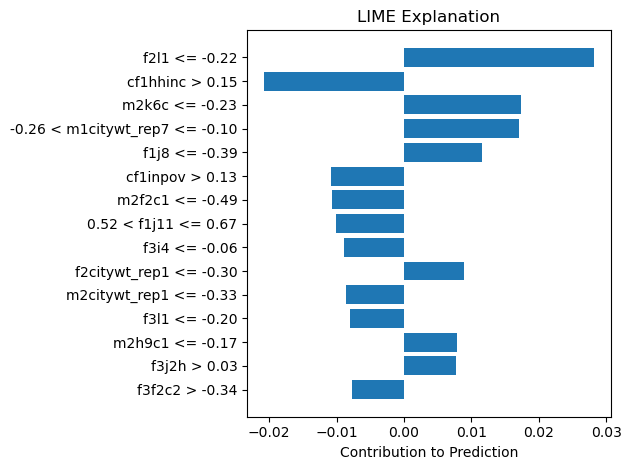

In [128]:
import matplotlib.pyplot as plt

# Get the explanation as a list of tuples
explanation = exp.as_list()

# Separate the features and their contributions
features, contributions = zip(*explanation)

# Create a bar plot
plt.barh(features, contributions)
plt.xlabel('Contribution to Prediction')
plt.title('LIME Explanation')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest contribution at the top
plt.tight_layout()

# Save the figure
plt.savefig('/Users/Applied Machine Learning/Summative/lime_explanation.png')

In [113]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': [None, 'sqrt', 'log2']
}

# Create a Gradient Boosting regressor
gb = GradientBoostingRegressor()

# Create the GridSearchCV object
grid = GridSearchCV(gb, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100, 'subsample': 0.7}
Best score: -0.24701704820239656


In [115]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Get the best parameters
best_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400, 'subsample': 0.5}

# Create a Gradient Boosting regressor with the best parameters
gb = GradientBoostingRegressor(**grid.best_params_)

# Fit the model to the data
gb.fit(X_train, y_train)

# Make predictions
y_pred = gb.predict(X_test)

# Compute the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.24192313684102407
Root Mean Squared Error: 0.49185682555091587
R^2 Score: -0.021419391438325608


##### Decision Tree

In [116]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 131)
X_val shape: (325, 131)
X_test shape: (319, 131)
Y_train shape: (1477,)
Y_val shape: (325,)
Y_test shape: (319,)


In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the parameter grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
dt = DecisionTreeRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=squared_error, max_depth=None, min_sa

In [118]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

dt = DecisionTreeRegressor(**best_params)

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Compute the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.2755192006269592
Root Mean Squared Error: 0.5248992290211134
R^2 Score: -0.12978262840563914


# Other Variables Hyper Parameter Tuning

### Feature Selection

#### LASSO

##### Grit

In [159]:
from sklearn.linear_model import Lasso
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [160]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()


models = [lr, ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

In [161]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 20093)
X_val shape: (325, 20093)
X_test shape: (319, 20093)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [162]:
# lasso = Lasso(alpha=0.1)

In [163]:
from sklearn.linear_model import Lasso

# Create a Lasso regressor with the best alpha
lasso = Lasso(alpha=0.01)

# Fit the model to the data
lasso.fit(X_train, y_train["grit"])

# Print the coefficients
print(f'Coefficients: {lasso.coef_}')

Coefficients: [-0.         -0.         -0.00381681 ...  0.         -0.
  0.        ]


In [164]:
# # Fit the Lasso model
# lasso.fit(X, y['gpa'])

In [165]:
# Get the coefficients of the features
feature_coefficients_grit = pd.Series(lasso.coef_, index=X.columns)

# Select the features with non-zero coefficients
lasso_selected_features_grit = feature_coefficients_grit[feature_coefficients_grit != 0].index

# Print the selected features
print(lasso_selected_features_grit)

Index(['f1e1d1', 'f1j11', 'cm1lenmin', 'm1citywt_rep5', 'cf2povcob', 'm2f2c4',
       'm2k6c', 'm2k10a', 'f3f2c1', 'f3l2a', 'cf3hhincb', 'q3citywt_rep2',
       'q3citywt_rep5', 'm3i8c2', 'm3k19', 'm3k21', 'ch3att_cd',
       'f4citywt_rep8', 'm4b8b', 'm4f2c3', 'm4i4', 'm4i8c2', 'm4j2e', 'm4j2f',
       'm4k8', 'm4k13', 'ch4mombmi', 'ch4mwtlb', 'ch4mwtkg', 'm5f8c2', 'm5i10',
       'h5m9a2', 'cf5hhinc', 'f1b13', 'f1b25', 'f3d7', 'm4d9', 'm4e23',
       'f1b15a_3.0', 'f1d3g_2.0', 'm1d3b_1.0', 'm1d3e_2.0', 'm1f1b_0.0',
       'f2d5a_1.0', 'f2k18c_1.0', 'f2l7_3.0', 'm2b20b_4.0', 'm2d3b2_1.0',
       'm2d3b2_2.0', 'f3d4_3.0', 'm3b5_1.0', 'm3b5_2.0', 'm3c7a_2.0',
       'm3c7b_1.0', 'p3g1c_5.0', 'f4i23p4_3.0', 'm4b6a_2.0', 'm4i0l_4.0',
       'm4i23p5_1.0', 'm4i23q2_3.0', 'm4k14a2_1.0', 'm4k14a2_2.0',
       'p4c17c_3.0', 'p4d17_4.0', 'p4l24_1.0', 'k5a2d_1.0', 'k5b1d_0.0',
       'm5i16c_1.0', 'f5i16a_4.0', 'p5h14_1.0', 'p5h14_2.0', 'p5i1e_3.0',
       'p5i21b_1.0', 'p5i21b_2.0', 'o5a8_2.0'

In [166]:
# y_train = np.ravel(y_train)
# y_test = np.ravel(y_test)

In [167]:
len(lasso_selected_features_grit)

80

In [168]:
from sklearn.linear_model import LinearRegression
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]


In [169]:
# Create the feature matrix X using the selected features
X = X[lasso_selected_features_grit]

# Create the target variable y
y = y['grit']

In [170]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 80)
X_val shape: (325, 80)
X_test shape: (319, 80)
Y_train shape: (1477,)
Y_val shape: (325,)
Y_test shape: (319,)


In [171]:
for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")


LinearRegression Mean Squared Error: 0.18548030853271485
LinearRegression Root Mean Squared Error (RMSE): 0.4306742487457485
LinearRegression R-squared: -0.1637882924576124
############################################
Ridge Mean Squared Error: 0.1869175141267477
Ridge Root Mean Squared Error (RMSE): 0.4323395819569933
Ridge R-squared: -0.17280597771715045
############################################
Lasso Mean Squared Error: 0.15946920309280607
Lasso Root Mean Squared Error (RMSE): 0.3993359526674327
Lasso R-squared: -0.0005827197242291859
############################################


ElasticNet Mean Squared Error: 0.15946920309280607
ElasticNet Root Mean Squared Error (RMSE): 0.3993359526674327
ElasticNet R-squared: -0.0005827197242291859
############################################
RandomForestRegressor Mean Squared Error: 0.16656901923076922
RandomForestRegressor Root Mean Squared Error (RMSE): 0.4081286797454563
RandomForestRegressor R-squared: -0.045130213554313015
############################################
GradientBoostingRegressor Mean Squared Error: 0.1677903163889582
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.40962216296113446
GradientBoostingRegressor R-squared: -0.05279319053314069
############################################
XGBRegressor Mean Squared Error: 0.18786031031344463
XGBRegressor Root Mean Squared Error (RMSE): 0.4334285527205662
XGBRegressor R-squared: -0.17872151221745058
############################################
DecisionTreeRegressor Mean Squared Error: 0.30230769230769233
DecisionTreeRegressor Root Mean Squared Error (

##### Material Hardship

In [172]:
from sklearn.linear_model import Lasso
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [173]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()

models = [lr, ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

In [174]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 20093)
X_val shape: (325, 20093)
X_test shape: (319, 20093)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [175]:
# lasso = Lasso(alpha=0.1)

In [176]:
from sklearn.linear_model import Lasso

# Create a Lasso regressor with the best alpha
lasso = Lasso(alpha=0.001)

# Fit the model to the data
lasso.fit(X_train, y_train["materialHardship"])

# Print the coefficients
print(f'Coefficients: {lasso.coef_}')

Coefficients: [ 0.00716743  0.         -0.         ...  0.          0.
 -0.01030201]


In [177]:
# # Fit the Lasso model
# lasso.fit(X, y['gpa'])

In [178]:
# Get the coefficients of the features
feature_coefficients_mh = pd.Series(lasso.coef_, index=X.columns)

# Select the features with non-zero coefficients
lasso_selected_features_mh = feature_coefficients_mh[feature_coefficients_mh != 0].index

# Print the selected features
print(lasso_selected_features_mh)

Index(['cf1lenmin', 'f1e1d2', 'f1e1d3', 'f1j6', 'f1j8', 'f1j11',
       'f1citywt_rep9', 'cm1lenmin', 'm1e1d1', 'm1e1d2',
       ...
       't5e22a_3.0', 't5f1b_1.0', 't5f1b_2.0', 't5f1c_2.0', 't5f1d_4.0',
       't5f3_5.0', 't5f4b_1.0', 'cm5b_age_111.0', 'cm5povca_3.0',
       'cf5samp_7.0'],
      dtype='object', length=803)


In [179]:
# y_train = np.ravel(y_train)
# y_test = np.ravel(y_test)

In [180]:
len(lasso_selected_features_mh)

803

In [181]:
from sklearn.linear_model import LinearRegression
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]


In [182]:
X = X[lasso_selected_features_mh]

In [183]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 803)
X_val shape: (325, 803)
X_test shape: (319, 803)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [184]:
for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train['materialHardship'])

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val['materialHardship'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val['materialHardship'], predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")


LinearRegression Mean Squared Error: 0.03682561786536269
LinearRegression Root Mean Squared Error (RMSE): 0.1919000204933879
LinearRegression R-squared: -0.9009734489450159
############################################
Ridge Mean Squared Error: 0.03648179026907999
Ridge Root Mean Squared Error (RMSE): 0.19100206875602155
Ridge R-squared: -0.8832247411314054
############################################
Lasso Mean Squared Error: 0.01941001690172446
Lasso Root Mean Squared Error (RMSE): 0.13931983671295506
Lasso R-squared: -0.0019635490884057916
############################################
ElasticNet Mean Squared Error: 0.01941001690172446
ElasticNet Root Mean Squared Error (RMSE): 0.13931983671295506
ElasticNet R-squared: -0.0019635490884057916
############################################
RandomForestRegressor Mean Squared Error: 0.021804165289256213
RandomForestRegressor Root Mean Squared Error (RMSE): 0.1476623353779027
RandomForestRegressor R-squared: -0.125551767870558
###############

#### Elastic Net

##### Grit

In [71]:
from sklearn.linear_model import Lasso
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [78]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()
decision_tree = DecisionTreeRegressor()

models = [lr, ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

In [79]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 20093)
X_val shape: (325, 20093)
X_test shape: (319, 20093)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [80]:
from sklearn.linear_model import ElasticNet

# Assuming X and y are your features and target variables
# Create an ElasticNet model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit the model
elastic_net.fit(X, y['grit'])

# Get the coefficients
coef = elastic_net.coef_

# Get the indices of the features selected by ElasticNet
selected_features_indices = np.where(coef != 0)[0]

# Get the names of the selected features
selected_features_names_grit = X.columns[selected_features_indices]

print(f"The selected features are: {selected_features_names_grit}")

The selected features are: Index(['cf1lenmin', 'f1e1d1', 'f1j11', 'f1citywt_rep3', 'cf2povcob', 'm2f2c3',
       'm2f2c4', 'f3f2c1', 'cf3povcob', 'ch3att_cd', 'cf4povcob',
       'f4citywt_rep8', 'm4b8b', 'm4k8', 'm4k13', 'ch4mombmi', 'ch4mwtlb',
       'ch4mwtkg', 'ch5wj9ss', 'f3d9', 'm1f1b_0.0', 'm2d3b2_1.0', 'm2d3b2_2.0',
       'f3r9_1.0', 'cm4cfevjail_0.0', 'cm4cfevjail_1.0', 'cm4fevjail_0.0',
       'cm4fevjail_1.0', 'k5a2d_0.0', 'k5b1d_0.0', 'p5i34_0.0', 't5a5_9.0'],
      dtype='object')


In [81]:
len(selected_features_names_grit)

32

In [82]:
# Create the feature matrix X using the selected features
X = X[selected_features_names_grit]

# Create the target variable y
# y = y['gpa']

In [191]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 32)
X_val shape: (325, 32)
X_test shape: (319, 32)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [192]:
# Create model objects
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()

models = [linear,  ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train['grit'])

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val['grit'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val['grit'], predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")

LinearRegression Mean Squared Error: 0.14858808077298677
LinearRegression Root Mean Squared Error (RMSE): 0.3854712450663302
LinearRegression R-squared: 0.06769041862011083
############################################
Ridge Mean Squared Error: 0.14842585821940296
Ridge Root Mean Squared Error (RMSE): 0.38526076651977287
Ridge R-squared: 0.0687082771201688
############################################
Lasso Mean Squared Error: 0.15946920309280607
Lasso Root Mean Squared Error (RMSE): 0.3993359526674327
Lasso R-squared: -0.0005827197242291859
############################################
ElasticNet Mean Squared Error: 0.15946920309280607
ElasticNet Root Mean Squared Error (RMSE): 0.3993359526674327
ElasticNet R-squared: -0.0005827197242291859
############################################


RandomForestRegressor Mean Squared Error: 0.16597144164320687
RandomForestRegressor Root Mean Squared Error (RMSE): 0.40739592737680486
RandomForestRegressor R-squared: -0.041380738444304344
############################################
GradientBoostingRegressor Mean Squared Error: 0.16543092355496716
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.4067320045865178
GradientBoostingRegressor R-squared: -0.03798928073145502
############################################
XGBRegressor Mean Squared Error: 0.19643147989894977
XGBRegressor Root Mean Squared Error (RMSE): 0.44320591139892274
XGBRegressor R-squared: -0.232500950558854
############################################
DecisionTreeRegressor Mean Squared Error: 0.3733737024221453
DecisionTreeRegressor Root Mean Squared Error (RMSE): 0.6110431264830211
DecisionTreeRegressor R-squared: -1.342717386162874
############################################


##### Material Hardship

In [83]:
from sklearn.linear_model import Lasso
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [84]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()

models = [lr, ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

In [85]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 20093)
X_val shape: (325, 20093)
X_test shape: (319, 20093)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [86]:
from sklearn.linear_model import ElasticNet

# Assuming X and y are your features and target variables
# Create an ElasticNet model
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5)

# Fit the model
elastic_net.fit(X, y['materialHardship'])

# Get the coefficients
coef = elastic_net.coef_

# Get the indices of the features selected by ElasticNet
selected_features_indices = np.where(coef != 0)[0]

# Get the names of the selected features
selected_features_names_mh = X.columns[selected_features_indices]

print(f"The selected features are: {selected_features_names_mh}")

The selected features are: Index(['f1citywt_rep9', 'cm1hhinc', 'cf3hhincb', 'f3citywt_rep3', 'm3k13',
       'ch4wjpr22', 'm5i10', 'm2d8', 'm5d20'],
      dtype='object')


In [87]:
len(selected_features_names_mh)

9

In [198]:
# Create the feature matrix X using the selected features
X = X[selected_features_names]

# Create the target variable y
# y = y['gpa']

In [199]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 9)
X_val shape: (325, 9)
X_test shape: (319, 9)
Y_train shape: (1477, 6)
Y_val shape: (325, 6)
Y_test shape: (319, 6)


In [200]:
# Create model objects
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()
decision_tree = DecisionTreeRegressor()

models = [linear,  ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train['materialHardship'])

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_val['materialHardship'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val['materialHardship'], predictions)

    print(f"{model.__class__.__name__} Mean Squared Error: {mse}")
    print(f"{model.__class__.__name__} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model.__class__.__name__} R-squared: {r2}")
    print("############################################")

LinearRegression Mean Squared Error: 0.019013145075269182
LinearRegression Root Mean Squared Error (RMSE): 0.1378881614761368
LinearRegression R-squared: 0.018523352380134472
############################################
Ridge Mean Squared Error: 0.019013134374867197
Ridge Root Mean Squared Error (RMSE): 0.13788812267511366
Ridge R-squared: 0.01852390474507082
############################################
Lasso Mean Squared Error: 0.01941001690172446
Lasso Root Mean Squared Error (RMSE): 0.13931983671295506
Lasso R-squared: -0.0019635490884057916
############################################
ElasticNet Mean Squared Error: 0.01941001690172446
ElasticNet Root Mean Squared Error (RMSE): 0.13931983671295506
ElasticNet R-squared: -0.0019635490884057916
############################################


RandomForestRegressor Mean Squared Error: 0.02196647807059066
RandomForestRegressor Root Mean Squared Error (RMSE): 0.14821092426198096
RandomForestRegressor R-squared: -0.13393050815047114
############################################
GradientBoostingRegressor Mean Squared Error: 0.02135471390250034
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.14613252171402621
GradientBoostingRegressor R-squared: -0.10235065944820465
############################################
XGBRegressor Mean Squared Error: 0.025059751223388674
XGBRegressor Root Mean Squared Error (RMSE): 0.15830272020211364
XGBRegressor R-squared: -0.29360821282068317
############################################
DecisionTreeRegressor Mean Squared Error: 0.0522033810345499
DecisionTreeRegressor Root Mean Squared Error (RMSE): 0.2284805922492103
DecisionTreeRegressor R-squared: -1.694788222010509
############################################


#### Eviction

##### With Train Data Imputation

In [74]:
df_eviction_merged = df_encoded.merge(train_resampled_eviction['eviction'], left_index=True, right_index=True)

In [75]:
X = df_eviction_merged.drop(['eviction'], axis=1)
y = df_eviction_merged['eviction']

In [76]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2834, 20093)
X_val shape: (623, 20093)
X_test shape: (611, 20093)
Y_train shape: (2834,)
Y_val shape: (623,)
Y_test shape: (611,)


In [204]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import ConvergenceWarning
import warnings

# Create model objects
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [205]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5200642054574639
LogisticRegression Precision: 0.5457413249211357
LogisticRegression Recall: 0.5274390243902439
LogisticRegression F1-score: 0.5364341085271318
############################################
DecisionTreeClassifier Accuracy: 0.5457463884430177
DecisionTreeClassifier Precision: 0.5732899022801303
DecisionTreeClassifier Recall: 0.5365853658536586
DecisionTreeClassifier F1-score: 0.5543307086614173
############################################
RandomForestClassifier Accuracy: 0.5393258426966292
RandomForestClassifier Precision: 0.563076923076923
RandomForestClassifier Recall: 0.5579268292682927
RandomForestClassifier F1-score: 0.5604900459418071
############################################
GradientBoostingClassifier Accuracy: 0.5280898876404494
GradientBoostingClassifier Precision: 0.554140127388535
GradientBoostingClassifier Recall: 0.5304878048780488
GradientBoostingClassifier F1-score: 0.5420560747663551
#######################################

##### LASSO

In [77]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

X = df_eviction_merged.drop(['eviction'], axis=1)
y = df_eviction_merged['eviction']


# Fit LassoCV for automatic alpha selection
lasso = Lasso(alpha=0.01)

lasso.fit(X, y)

# Get the feature names
feature_names = X.columns

# Get the coefficients
coefficients = lasso.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Keep only the features with non-zero coefficients
selected_features_eviction_lasso = features_df[features_df['Coefficient'] != 0]['Feature']

print(selected_features_eviction_lasso)

26              m1e1d3
79              m2b21a
88                m2h4
96               m2l6b
116               f3i4
117              f3j2f
152              m3b7a
155             m3f2c2
172      m3citywt_rep2
205         ch3ppvtstd
209       ch3ppvtage_m
210           ch3att_t
260             m4i8c2
270              m4l6c
291         ch4wjrmi22
318             m5f8c2
322              m5i21
364        cm5b_ageyrs
369           cm5povco
376              f1b13
378               m2d6
379               m2d8
387               m4d9
390               f4d7
4981        m2k16_52.0
9269         p3m49_1.0
9675         f4a10_2.0
11981         m4i0_1.0
12289         m4j1_2.0
14866        k5a1b_3.0
14890        k5a2c_3.0
15778         m5g0_2.0
Name: Feature, dtype: object


In [78]:
X = X[selected_features_eviction_lasso]

In [79]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2834, 32)
X_val shape: (623, 32)
X_test shape: (611, 32)
Y_train shape: (2834,)
Y_val shape: (623,)
Y_test shape: (611,)


In [209]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5682182985553772
LogisticRegression Precision: 0.6035087719298246
LogisticRegression Recall: 0.524390243902439
LogisticRegression F1-score: 0.5611745513866232
############################################
DecisionTreeClassifier Accuracy: 0.5200642054574639
DecisionTreeClassifier Precision: 0.5478547854785478
DecisionTreeClassifier Recall: 0.5060975609756098
DecisionTreeClassifier F1-score: 0.526148969889065
############################################


RandomForestClassifier Accuracy: 0.507223113964687
RandomForestClassifier Precision: 0.5327102803738317
RandomForestClassifier Recall: 0.5213414634146342
RandomForestClassifier F1-score: 0.5269645608628659
############################################
GradientBoostingClassifier Accuracy: 0.5264847512038523
GradientBoostingClassifier Precision: 0.5555555555555556
GradientBoostingClassifier Recall: 0.5030487804878049
GradientBoostingClassifier F1-score: 0.528
############################################


##### Elastic Net

In [80]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

X = df_eviction_merged.drop(['eviction'], axis=1)
y = df_eviction_merged['eviction']


# Fit ElasticNetCV for automatic alpha and l1_ratio selection

enet = ElasticNet(alpha=0.1, l1_ratio=0.1)
enet.fit(X, y)

# Get the feature names
feature_names = X.columns

# Get the coefficients
coefficients = enet.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Keep only the features with non-zero coefficients
selected_features_eviction_en = features_df[features_df['Coefficient'] != 0]['Feature']

print(selected_features_eviction_en)

16       f1citywt_rep5
26              m1e1d3
79              m2b21a
88                m2h4
96               m2l6b
116               f3i4
117              f3j2f
152              m3b7a
155             m3f2c2
172      m3citywt_rep2
205         ch3ppvtstd
209       ch3ppvtage_m
210           ch3att_t
260             m4i8c2
270              m4l6c
291         ch4wjrmi22
318             m5f8c2
320              m5i13
322              m5i21
364        cm5b_ageyrs
369           cm5povco
376              f1b13
378               m2d6
379               m2d8
387               m4d9
390               f4d7
4981        m2k16_52.0
9268         p3m49_0.0
9269         p3m49_1.0
9675         f4a10_2.0
11763       m4f2c4_5.0
11895      cm4kids_2.0
11981         m4i0_1.0
11982         m4i0_2.0
12289         m4j1_2.0
14866        k5a1b_3.0
14890        k5a2c_3.0
15778         m5g0_2.0
Name: Feature, dtype: object


In [81]:
X = X[selected_features_eviction_en]

In [82]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2834, 38)
X_val shape: (623, 38)
X_test shape: (611, 38)
Y_train shape: (2834,)
Y_val shape: (623,)
Y_test shape: (611,)


In [148]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


NameError: name 'accuracy_score' is not defined

#### Job Training

##### With Train Data Imputation

In [83]:
X = merged_df.drop(['gpa','grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'], axis=1)
y = merged_df[['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']]

In [84]:
df_jobTraining_merged = df_encoded.merge(train_resampled_jobTraining['jobTraining'], left_index=True, right_index=True)

In [85]:
X = df_jobTraining_merged.drop(['jobTraining'], axis=1)
y = df_jobTraining_merged['jobTraining']

In [86]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2478, 20093)
X_val shape: (544, 20093)
X_test shape: (534, 20093)
Y_train shape: (2478,)
Y_val shape: (544,)
Y_test shape: (534,)


In [218]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.48713235294117646
LogisticRegression Precision: 0.5019157088122606
LogisticRegression Recall: 0.46785714285714286
LogisticRegression F1-score: 0.48428835489833644
############################################
DecisionTreeClassifier Accuracy: 0.4834558823529412
DecisionTreeClassifier Precision: 0.4980237154150198
DecisionTreeClassifier Recall: 0.45
DecisionTreeClassifier F1-score: 0.4727954971857411
############################################
RandomForestClassifier Accuracy: 0.5055147058823529
RandomForestClassifier Precision: 0.5219123505976095
RandomForestClassifier Recall: 0.46785714285714286
RandomForestClassifier F1-score: 0.4934086629001883
############################################
GradientBoostingClassifier Accuracy: 0.5238970588235294
GradientBoostingClassifier Precision: 0.5373665480427047
GradientBoostingClassifier Recall: 0.5392857142857143
GradientBoostingClassifier F1-score: 0.5383244206773619
############################################


##### LASSO

In [219]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

X = df_jobTraining_merged.drop(['jobTraining'], axis=1)
y = df_jobTraining_merged['jobTraining']


lasso = Lasso(alpha=0.01)

lasso.fit(X, y)

# Get the feature names
feature_names = X.columns

# Get the coefficients
coefficients = lasso.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Keep only the features with non-zero coefficients
selected_features_jobTraining_lasso = features_df[features_df['Coefficient'] != 0]['Feature']

print(selected_features_jobTraining_lasso)

13        f1citywt_rep2
28                m1i2b
36        m1citywt_rep3
53             cf2hhinc
54            cf2hhincb
79               m2b21a
88                 m2h4
105       m2citywt_rep6
116                f3i4
118               f3j2h
139      f3citywt_rep10
155              m3f2c2
172       m3citywt_rep2
187             ch3bmip
206          ch3ppvtraw
210            ch3att_t
215              f4f2c1
270               m4l6c
295           ch4cbmi_p
299              ch4haz
308              ch4whp
318              m5f8c2
320               m5i13
342           ch5wj10ss
364         cm5b_ageyrs
369            cm5povco
374               m1b25
392               m5d20
822            f1e4_1.0
823            f1e4_2.0
11642         m4d1c_1.0
11981          m4i0_1.0
11982          m4i0_2.0
12289          m4j1_2.0
13587        p4d15c_2.0
15094         k5g1c_3.0
Name: Feature, dtype: object


In [220]:
X = X[selected_features_jobTraining_lasso]

In [221]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2478, 36)
X_val shape: (544, 36)
X_test shape: (534, 36)
Y_train shape: (2478,)
Y_val shape: (544,)
Y_test shape: (534,)


In [222]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5753676470588235
LogisticRegression Precision: 0.584192439862543
LogisticRegression Recall: 0.6071428571428571
LogisticRegression F1-score: 0.5954465849387041
############################################
DecisionTreeClassifier Accuracy: 0.5
DecisionTreeClassifier Precision: 0.5143884892086331
DecisionTreeClassifier Recall: 0.5107142857142857
DecisionTreeClassifier F1-score: 0.5125448028673835
############################################


RandomForestClassifier Accuracy: 0.5496323529411765
RandomForestClassifier Precision: 0.5636363636363636
RandomForestClassifier Recall: 0.5535714285714286
RandomForestClassifier F1-score: 0.5585585585585585
############################################
GradientBoostingClassifier Accuracy: 0.5606617647058824
GradientBoostingClassifier Precision: 0.5724381625441696
GradientBoostingClassifier Recall: 0.5785714285714286
GradientBoostingClassifier F1-score: 0.5754884547069272
############################################


##### Elastic Net

In [87]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

X = df_jobTraining_merged.drop(['jobTraining'], axis=1)
y = df_jobTraining_merged['jobTraining']


# Fit ElasticNetCV for automatic alpha and l1_ratio selection
enet = ElasticNet(alpha=0.1, l1_ratio=0.1)
enet.fit(X, y)

# Get the feature names
feature_names = X.columns

# Get the coefficients
coefficients = enet.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Keep only the features with non-zero coefficients
selected_features_jobTraining_en = features_df[features_df['Coefficient'] != 0]['Feature']

print(selected_features_jobTraining_en)

13        f1citywt_rep2
28                m1i2b
36        m1citywt_rep3
53             cf2hhinc
54            cf2hhincb
72        q2citywt_rep5
79               m2b21a
88                 m2h4
105       m2citywt_rep6
116                f3i4
118               f3j2h
139      f3citywt_rep10
155              m3f2c2
172       m3citywt_rep2
187             ch3bmip
205          ch3ppvtstd
206          ch3ppvtraw
210            ch3att_t
215              f4f2c1
270               m4l6c
295           ch4cbmi_p
299              ch4haz
308              ch4whp
318              m5f8c2
320               m5i13
342           ch5wj10ss
364         cm5b_ageyrs
369            cm5povco
374               m1b25
392               m5d20
822            f1e4_1.0
823            f1e4_2.0
11642         m4d1c_1.0
11981          m4i0_1.0
11982          m4i0_2.0
12289          m4j1_2.0
13587        p4d15c_2.0
15094         k5g1c_3.0
Name: Feature, dtype: object


In [88]:
X = X[selected_features_jobTraining_en]

In [89]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2478, 38)
X_val shape: (544, 38)
X_test shape: (534, 38)
Y_train shape: (2478,)
Y_val shape: (544,)
Y_test shape: (534,)


In [90]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5735294117647058
LogisticRegression Precision: 0.5821917808219178
LogisticRegression Recall: 0.6071428571428571
LogisticRegression F1-score: 0.5944055944055944
############################################
DecisionTreeClassifier Accuracy: 0.5110294117647058
DecisionTreeClassifier Precision: 0.5257352941176471
DecisionTreeClassifier Recall: 0.5107142857142857
DecisionTreeClassifier F1-score: 0.5181159420289855
############################################


RandomForestClassifier Accuracy: 0.5275735294117647
RandomForestClassifier Precision: 0.5465587044534413
RandomForestClassifier Recall: 0.48214285714285715
RandomForestClassifier F1-score: 0.5123339658444023
############################################
GradientBoostingClassifier Accuracy: 0.5514705882352942
GradientBoostingClassifier Precision: 0.5633802816901409
GradientBoostingClassifier Recall: 0.5714285714285714
GradientBoostingClassifier F1-score: 0.5673758865248227
############################################


#### Layoff

##### With Train Data Imputation

In [91]:
df_layoff_merged =  df_encoded.merge(train_resampled_layoff['layoff'], left_index=True, right_index=True)

In [92]:
X = df_layoff_merged.drop(['layoff'], axis=1)
y = df_layoff_merged['layoff']

In [93]:
df_layoff_merged['layoff'].value_counts()

layoff
0.0    1854
1.0    1854
Name: count, dtype: int64

In [94]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2583, 20093)
X_val shape: (568, 20093)
X_test shape: (557, 20093)
Y_train shape: (2583,)
Y_val shape: (568,)
Y_test shape: (557,)


In [231]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5211267605633803
LogisticRegression Precision: 0.5451388888888888
LogisticRegression Recall: 0.5268456375838926
LogisticRegression F1-score: 0.5358361774744027
############################################
DecisionTreeClassifier Accuracy: 0.49119718309859156
DecisionTreeClassifier Precision: 0.5161290322580645
DecisionTreeClassifier Recall: 0.48322147651006714
DecisionTreeClassifier F1-score: 0.49913344887348354
############################################
RandomForestClassifier Accuracy: 0.4595070422535211
RandomForestClassifier Precision: 0.4826254826254826
RandomForestClassifier Recall: 0.41946308724832215
RandomForestClassifier F1-score: 0.4488330341113106
############################################
GradientBoostingClassifier Accuracy: 0.46830985915492956
GradientBoostingClassifier Precision: 0.493006993006993
GradientBoostingClassifier Recall: 0.47315436241610737
GradientBoostingClassifier F1-score: 0.4828767123287671
################################

##### LASSO

In [232]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

X = df_layoff_merged.drop(['layoff'], axis=1)
y = df_layoff_merged['layoff']


lasso = Lasso(alpha=0.01)

lasso.fit(X, y)

# Get the feature names
feature_names = X.columns

# Get the coefficients
coefficients = lasso.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Keep only the features with non-zero coefficients
selected_features_layoff_lasso = features_df[features_df['Coefficient'] != 0]['Feature']

print(selected_features_layoff_lasso)

13        f1citywt_rep2
28                m1i2b
51                f2l6b
88                 m2h4
116                f3i4
118               f3j2h
122                f3l1
139      f3citywt_rep10
152               m3b7a
155              m3f2c2
210            ch3att_t
262               m4j2f
270               m4l6c
291          ch4wjrmi22
312             m5a5c03
322               m5i21
356              ch5hap
369            cm5povco
376               f1b13
377               f1b25
379                m2d8
384                f3d9
2973          f2j21_3.0
4981         m2k16_52.0
11484         m4c7a_1.0
12289          m4j1_2.0
13752         p4f1l_4.0
15315       m5a8f03_4.0
17468         p5i13_4.0
18430        p5q3bj_2.0
Name: Feature, dtype: object


In [233]:
X = X[selected_features_layoff_lasso]

In [234]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2583, 30)
X_val shape: (568, 30)
X_test shape: (557, 30)
Y_train shape: (2583,)
Y_val shape: (568,)
Y_test shape: (557,)


In [235]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5827464788732394
LogisticRegression Precision: 0.6055363321799307
LogisticRegression Recall: 0.587248322147651
LogisticRegression F1-score: 0.596252129471891
############################################
DecisionTreeClassifier Accuracy: 0.5088028169014085
DecisionTreeClassifier Precision: 0.5326460481099656
DecisionTreeClassifier Recall: 0.5201342281879194
DecisionTreeClassifier F1-score: 0.5263157894736842
############################################


RandomForestClassifier Accuracy: 0.5545774647887324
RandomForestClassifier Precision: 0.5778546712802768
RandomForestClassifier Recall: 0.5604026845637584
RandomForestClassifier F1-score: 0.5689948892674617
############################################
GradientBoostingClassifier Accuracy: 0.5492957746478874
GradientBoostingClassifier Precision: 0.5714285714285714
GradientBoostingClassifier Recall: 0.5637583892617449
GradientBoostingClassifier F1-score: 0.5675675675675675
############################################


##### Elastic Net

In [95]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

X = df_layoff_merged.drop(['layoff'], axis=1)
y = df_layoff_merged['layoff']


# Fit ElasticNetCV for automatic alpha and l1_ratio selection
enet = ElasticNet(alpha=0.1, l1_ratio=0.1)
enet.fit(X, y)

# Get the feature names
feature_names = X.columns

# Get the coefficients
coefficients = enet.coef_

# Create a DataFrame with the features and coefficients
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Keep only the features with non-zero coefficients
selected_features_layoff_en = features_df[features_df['Coefficient'] != 0]['Feature']

print(selected_features_layoff_en)

13        f1citywt_rep2
28                m1i2b
51                f2l6b
88                 m2h4
118               f3j2h
122                f3l1
139      f3citywt_rep10
152               m3b7a
155              m3f2c2
161               m3k10
210            ch3att_t
219               f4j2e
262               m4j2f
270               m4l6c
291          ch4wjrmi22
322               m5i21
356              ch5hap
369            cm5povco
376               f1b13
377               f1b25
379                m2d8
384                f3d9
2973          f2j21_3.0
4981         m2k16_52.0
11484         m4c7a_1.0
12289          m4j1_2.0
13752         p4f1l_4.0
15315       m5a8f03_4.0
17468         p5i13_4.0
18430        p5q3bj_2.0
Name: Feature, dtype: object


In [96]:
X = X[selected_features_layoff_en]

In [97]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2583, 30)
X_val shape: (568, 30)
X_test shape: (557, 30)
Y_train shape: (2583,)
Y_val shape: (568,)
Y_test shape: (557,)


In [98]:
models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Use the model to make predictions on the test data
    predictions = model.predict(X_val)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"{model.__class__.__name__} Precision: {precision}")
    print(f"{model.__class__.__name__} Recall: {recall}")
    print(f"{model.__class__.__name__} F1-score: {f1}")
    print("############################################")


LogisticRegression Accuracy: 0.5827464788732394
LogisticRegression Precision: 0.6048109965635738
LogisticRegression Recall: 0.5906040268456376
LogisticRegression F1-score: 0.597623089983022
############################################
DecisionTreeClassifier Accuracy: 0.5193661971830986
DecisionTreeClassifier Precision: 0.5412541254125413
DecisionTreeClassifier Recall: 0.5503355704697986
DecisionTreeClassifier F1-score: 0.5457570715474209
############################################


RandomForestClassifier Accuracy: 0.551056338028169
RandomForestClassifier Precision: 0.5723905723905723
RandomForestClassifier Recall: 0.5704697986577181
RandomForestClassifier F1-score: 0.5714285714285714
############################################
GradientBoostingClassifier Accuracy: 0.5422535211267606
GradientBoostingClassifier Precision: 0.5637583892617449
GradientBoostingClassifier Recall: 0.5637583892617449
GradientBoostingClassifier F1-score: 0.5637583892617449
############################################


### Parameter Tuning

#### Grit

In [88]:
from sklearn.linear_model import Lasso
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[[ 'grit']]

In [90]:
X = X[selected_features_names_grit]

In [91]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()


models = [lr, ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

In [92]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 32)
X_val shape: (325, 32)
X_test shape: (319, 32)
Y_train shape: (1477, 1)
Y_val shape: (325, 1)
Y_test shape: (319, 1)


##### Decision Tree

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the parameter grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
dt = DecisionTreeRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_sa

In [94]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

dt = DecisionTreeRegressor(**best_params)

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_val)

# Compute the Mean Squared Error
mse = mean_squared_error(y_val, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.16865384615384615
Root Mean Squared Error: 0.4106748667179989
R^2 Score: -0.05821137124739173


##### Random Forest

In [95]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 32)
X_val shape: (325, 32)
X_test shape: (319, 32)
Y_train shape: (1477, 1)
Y_val shape: (325, 1)
Y_test shape: (319, 1)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create a RandomForestRegressor
rf = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters are: {best_params}")

In [ ]:
#The best parameters are: {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 200}

In [97]:
rf = RandomForestRegressor(**best_params)

# Fit the model to the data
rf.fit(X, y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=50, min_samples_leaf=8, min_samples_split=5,
                      n_estimators=200)

In [98]:
predictions = rf.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

In [99]:
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.07792908276682223
Root Mean Squared Error (RMSE): 0.27915780979012966
R-squared: 0.44427394133203


##### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Gradient Boosting regressor
gb = GradientBoostingRegressor()

# Create the GridSearchCV object
grid = GridSearchCV(gb, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [ ]:
#Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.5}
#Best score: -0.15620584997703246

In [101]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Get the best parameters
best_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400, 'subsample': 0.5}

# Create a Gradient Boosting regressor with the best parameters
gb = GradientBoostingRegressor(**best_params)

# Fit the model to the data
gb.fit(X, y)

# Make predictions
y_pred = gb.predict(X)

# Compute the Mean Squared Error
mse = mean_squared_error(y, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Mean Squared Error: 0.09254941272951471
Root Mean Squared Error: 0.30421934969609465
R^2 Score: 0.4157120403904849


#### Material Hardship

In [102]:
from sklearn.linear_model import Lasso
X = merged_df.drop(columns=['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining', 'challengeID'])
y = merged_df[[ 'materialHardship']]

In [103]:
X = X[selected_features_names_mh]

In [104]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgboost = XGBRegressor()


models = [lr, ridge, lasso, elastic_net, random_forest, gradient_boosting, xgboost, decision_tree]

In [105]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 9)
X_val shape: (325, 9)
X_test shape: (319, 9)
Y_train shape: (1477, 1)
Y_val shape: (325, 1)
Y_test shape: (319, 1)


##### Decision Tree

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the parameter grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
dt = DecisionTreeRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_sa

In [107]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

dt = DecisionTreeRegressor(**best_params)

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_val)

# Compute the Mean Squared Error
mse = mean_squared_error(y_val, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.02374486144337099
Root Mean Squared Error: 0.15409367749317618
R^2 Score: -0.2257323507172584


##### Random Forest

In [108]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 9)
X_val shape: (325, 9)
X_test shape: (319, 9)
Y_train shape: (1477, 1)
Y_val shape: (325, 1)
Y_test shape: (319, 1)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create a RandomForestRegressor
rf = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters are: {best_params}")

In [ ]:
#The best parameters are: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 300}

In [110]:
rf = RandomForestRegressor(**best_params)

# Fit the model to the data
rf.fit(X, y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=20,
                      n_estimators=300)

In [111]:
predictions = rf.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

In [112]:
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.011903747540887256
Root Mean Squared Error (RMSE): 0.10910429661973563
R-squared: 0.20106940109835658


##### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Gradient Boosting regressor
gb = GradientBoostingRegressor()

# Create the GridSearchCV object
grid = GridSearchCV(gb, params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid.fit(X, y)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [ ]:
#Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.5}
#Best score: -0.018744209087079043

In [114]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Get the best parameters
best_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400, 'subsample': 0.5}

# Create a Gradient Boosting regressor with the best parameters
gb = GradientBoostingRegressor(**best_params)

# Fit the model to the data
gb.fit(X, y)

# Make predictions
y_pred = gb.predict(X)

# Compute the Mean Squared Error
mse = mean_squared_error(y, y_pred)

# Compute the Root Mean Squared Error
rmse = sqrt(mse)

# Compute the R^2 score
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Mean Squared Error: 0.011675585468150687
Root Mean Squared Error: 0.10805362311440875
R^2 Score: 0.38445838809783617


#### Eviction

In [91]:
X = df_eviction_merged.drop(['eviction'], axis=1)
y = df_eviction_merged['eviction']

In [92]:
X = X[selected_features_eviction_en]

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.exceptions import ConvergenceWarning

# Create model objects
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [120]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (1477, 20093)
X_val shape: (325, 20093)
X_test shape: (319, 20093)
Y_train shape: (1477, 1)
Y_val shape: (325, 1)
Y_test shape: (319, 1)


##### Decision Tree

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
dt = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max

In [150]:
from sklearn.metrics import accuracy_score, f1_score

dt = DecisionTreeClassifier(**best_params)

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.5482815057283142
F1 Score: 0.5106382978723404


##### Random Forest

In [151]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2834, 38)
X_val shape: (623, 38)
X_test shape: (611, 38)
Y_train shape: (2834,)
Y_val shape: (623,)
Y_test shape: (611,)


In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create a RandomForestClassifier
rf = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters are: {best_params}")

The best parameters are: {'max_depth': 40, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 200}


In [153]:
rf = RandomForestClassifier(**best_params)

# Fit the model to the data
rf.fit(X, y)

RandomForestClassifier(max_depth=40, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=200)

In [158]:
best_params_rf = {'max_depth': 40, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 200}

In [159]:
rf = RandomForestClassifier(**best_params_rf)

# Fit the model to the data
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=200)

In [160]:
# Make predictions
y_pred = rf.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.5204582651391162
F1 Score: 0.5266558966074314


##### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Gradient Boosting classifier
gb = GradientBoostingClassifier()

# Create the GridSearchCV object
grid = GridSearchCV(gb, params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [ ]:
#Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 300, 'subsample': 1.0}
#Best score: 0.5609741652047442

In [103]:
from sklearn.metrics import accuracy_score, f1_score

In [104]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# # Get the best parameters
# best_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400, 'subsample': 0.5}

# Create a Gradient Boosting regressor with the best parameters
gb = GradientBoostingClassifier(learning_rate=0.01, max_depth = 6, max_features = 'log2', n_estimators = 300, subsample = 1.0)

# Fit the model to the data
gb.fit(X_train, y_train)

# Make predictions
y_pred = gb.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.5350089766606823
F1 Score: 0.5212569316081331


#### Layoff

In [105]:
X = df_layoff_merged.drop(['layoff'], axis=1)
y = df_layoff_merged['layoff']

In [106]:
X = X[selected_features_layoff_en]

In [107]:

# Create model objects
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [108]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2583, 30)
X_val shape: (568, 30)
X_test shape: (557, 30)
Y_train shape: (2583,)
Y_val shape: (568,)
Y_test shape: (557,)


##### Decision Tree

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
dt = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini,

In [110]:
from sklearn.metrics import accuracy_score, f1_score

dt = DecisionTreeClassifier(**best_params)

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.4919210053859964
F1 Score: 0.46502835538752363


##### Random Forest

In [111]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2583, 30)
X_val shape: (568, 30)
X_test shape: (557, 30)
Y_train shape: (2583,)
Y_val shape: (568,)
Y_test shape: (557,)


In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create a RandomForestClassifier
rf = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters are: {best_params}")

The best parameters are: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [113]:
rf = RandomForestClassifier(**best_params)

# Fit the model to the data
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=300)

In [114]:
# Make predictions
y_pred = rf.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.5421903052064632
F1 Score: 0.5470692717584369


##### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Gradient Boosting classifier
gb = GradientBoostingClassifier()

# Create the GridSearchCV object
grid = GridSearchCV(gb, params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [ ]:
#Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 400, 'subsample': 1.0}
#Best score: 0.5594252770155789

In [101]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# # Get the best parameters
# best_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400, 'subsample': 0.5}

# Create a Gradient Boosting regressor with the best parameters
gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 5, max_features = 'sqrt', n_estimators = 400, subsample = 1.0)

# Fit the model to the data
gb.fit(X_train, y_train)

# Make predictions
y_pred = gb.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.5421903052064632
F1 Score: 0.5303867403314917


#### Job Training

In [102]:
X = df_jobTraining_merged.drop(['jobTraining'], axis=1)
y = df_jobTraining_merged['jobTraining']

In [103]:
X = X[selected_features_jobTraining_en]

In [104]:

# Create model objects
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

models = [logistic_regression, decision_tree, random_forest, gradient_boosting]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [105]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2478, 38)
X_val shape: (544, 38)
X_test shape: (534, 38)
Y_train shape: (2478,)
Y_val shape: (544,)
Y_test shape: (534,)


##### Decision Tree

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
dt = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total t

In [107]:
from sklearn.metrics import accuracy_score, f1_score

dt = DecisionTreeClassifier(**best_params)

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.4812734082397004
F1 Score: 0.36613272311212813


##### Random Forest

In [108]:
from sklearn.model_selection import train_test_split

# First split: 85% for a temporary training set, 15% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 82% of the temporary training set for the final training set, 18% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_val shape:", y_val.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (2478, 38)
X_val shape: (544, 38)
X_test shape: (534, 38)
Y_train shape: (2478,)
Y_val shape: (544,)
Y_test shape: (534,)


In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create a RandomForestClassifier
rf = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters are: {best_params}")

The best parameters are: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [110]:
rf = RandomForestClassifier(**best_params)

# Fit the model to the data
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20)

In [111]:
# Make predictions
y_pred = rf.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.5449438202247191
F1 Score: 0.5335892514395394


##### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Gradient Boosting classifier
gb = GradientBoostingClassifier()

# Create the GridSearchCV object
grid = GridSearchCV(gb, params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [ ]:
#Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.5}
#Best score: 0.5508455522971653

In [113]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# # Get the best parameters
# best_params = {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400, 'subsample': 0.5}

# Create a Gradient Boosting regressor with the best parameters
gb = GradientBoostingClassifier(learning_rate = 0.2, max_depth = 6, max_features = 'sqrt', n_estimators = 300, subsample = 0.5)

# Fit the model to the data
gb.fit(X_train, y_train)

# Make predictions
y_pred = gb.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)  

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.5224719101123596
F1 Score: 0.5215759849906192
